In [1]:
"""
Plot relative SSH time series/trends from reconstructions, state estimates, and obs
"""

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sys
import os
from os.path import join,expanduser,split,exists
import glob


user_home_dir = expanduser('~')

parent_dir = split(os.getcwd())[0]

sys.path.append(join(parent_dir,'filter_stat_modules'))
from filter_functions import *
from stat_functions import *

sys.path.append(join(parent_dir,'contribs_modules'))
from forcsens_read import *


# grid file
grid_filename = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC','ECCO_L4_GEOMETRY_LLC0090GRID_V4R4',\
                     'GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc')
ds_grid = xr.open_dataset(grid_filename)


# # adjoint sensitivities location
adj_sens_loc = 'EasternGulfCoast'

# # reconstruction location
place_id = 'EasternGulfCoast'

# # max lead identifier
maxlead_id = '5yr'

# # years included in prediction
years_to_predict = np.arange(1997,2018)
year_range_id = "_".join([str(year) for year in years_to_predict[[0,-1]]])


# reconstruction time series

varexp_dir = join(user_home_dir,'Downloads','ECCO_v4r4_adjoint','forcing_stats')

# ERA5_reconstr_filename = join(varexp_dir,'ERA5_impact_altim_'+place_id+'_withtrend_GulfNAtl_regions_1993_2022')
ERA5_reconstr_filename = join(varexp_dir,'ERA5_JRA55do_impact_altim_'+place_id+'_withtrend_GulfNAtl_regions_'\
                                +maxlead_id+'_1984_2022')

ECCO_reconstr_filename = join(varexp_dir,'ECCO_JRA55do_impact_altim_'+place_id+'_withtrend_GulfNAtl_regions_'\
                              +maxlead_id+'_1997_2017')
# ECCO_reconstr_filename = join(varexp_dir,'ECCO_JRA55do_impact_altim_'+place_id+'_withtrend_GulfNAtl_regions_'\
#                               +maxlead_id+'_1993_2017')





def ecco_mask_read(place_id):
    # read in ECCO grid mask for current region
    mask_unshaped = np.fromfile(join(expanduser('~'),'Downloads','ECCO_v4r4_adjoint',\
                                     'adjoint_sensitivities',place_id,\
                                'mask_'+place_id+'.bin'),dtype='>f4')
    mask_regionavg = np.empty((13,90,90)).astype('float32')
    mask_regionavg[:7,:,:] = np.reshape(mask_unshaped[:(7*90*90)],(7,90,90))
    mask_rot = np.reshape(mask_unshaped[(7*90*90):],(180,270))
    for tile_ind in range(7,10):
        mask_regionavg[tile_ind,:,:] = mask_rot[:90,90*(tile_ind-7):90*(tile_ind-6)]
    for tile_ind in range(10,13):
        mask_regionavg[tile_ind,:,:] = mask_rot[90:,90*(tile_ind-10):90*(tile_ind-9)]
    
    return mask_regionavg



# def ecco_mask_in_latlon_grid(ds_ECCO_grid,mask_regionavg,ds_latlon_grid):
#     """Indices and area-weighting needed to apply ECCO coast mask in lat-lon gridded data (e.g., altimetry)."""
    
#     # indices in ECCO coastal mask
#     ECCO_ind_in_mask = (mask_regionavg > .01).nonzero()

#     # in masked-region ECCO cell boundaries

#     mask_cell_lon_bnds = ds_ECCO_grid.XC_bnds.values[ECCO_ind_in_mask+(slice(None),)]
#     # make sure there is no branch cut across cell lon coordinates
#     mask_cell_lon_mod_basis = np.nanmin(mask_cell_lon_bnds) - 180
#     mask_cell_lon_bnds = ((mask_cell_lon_bnds - mask_cell_lon_mod_basis) % 360)\
#                             + mask_cell_lon_mod_basis

#     mask_cell_lat_bnds = ds_ECCO_grid.YC_bnds.values[ECCO_ind_in_mask+(slice(None),)]

#     mask_cell_lon_outside_bnds = np.array([np.nanmin(mask_cell_lon_bnds),\
#                                            np.nanmax(mask_cell_lon_bnds)])
#     mask_cell_lat_outside_bnds = np.array([np.nanmin(mask_cell_lat_bnds),\
#                                            np.nanmax(mask_cell_lat_bnds)])

#     # latlon gridded dataset coordinates and cell boundaries
#     llgridded_lon = np.pad(ds_latlon_grid.lon.values,pad_width=(0,1),mode='wrap').astype('float64')
#     llgridded_lon = np.hstack((llgridded_lon[0],\
#                                 llgridded_lon[:-1]\
#                                 + (((np.diff(llgridded_lon) - (-180)) % 360) - 180)))

#     llgridded_lon_bnds = llgridded_lon[:-1] + (np.diff(llgridded_lon)/2)
#     llgridded_lon_bnds = np.pad(llgridded_lon_bnds,pad_width=(1,0),mode='wrap')
#     llgridded_lon_bnds[0] = llgridded_lon_bnds[1] - (((np.diff(llgridded_lon_bnds[:2]) - (-180)) % 360) - 180)
#     llgridded_lon = llgridded_lon[:-1]

#     llgridded_lat = ds_latlon_grid.lat.values
#     llgridded_lat_bnds = llgridded_lat[:-1] + (np.diff(llgridded_lat)/2)

#     if np.nanmean(np.diff(llgridded_lon_bnds)) < 0:
#         llgridded_lon_bnds = llgridded_lon_bnds[::-1]
#     if np.nanmean(np.diff(llgridded_lat_bnds)) < 0:
#         llgridded_lat_bnds = llgridded_lat_bnds[::-1]

#     llgridded_lat_bnds = np.hstack((np.array([-90]),llgridded_lat_bnds,np.array([90])))

#     def llgridded_cell_ind_in_bounds(llgridded_lon_bnds,llgridded_lat_bnds,search_lon_bnds,search_lat_bnds):
#         llgridded_inregion_lon_ind = \
#             np.logical_or((llgridded_lon_bnds[:-1] - (search_lon_bnds[0] + 1.e-5)) % 360\
#                            < ((np.diff(search_lon_bnds) - 2.e-5) % 360),\
#                           (llgridded_lon_bnds[1:] - (search_lon_bnds[0] + 1.e-5)) % 360\
#                            < ((np.diff(search_lon_bnds) - 2.e-5) % 360)).nonzero()[0]
#         llgridded_inregion_lat_ind = np.logical_and(llgridded_lat_bnds[1:] > search_lat_bnds[0] + 1.e-5,\
#                                                   llgridded_lat_bnds[:-1] < search_lat_bnds[1] - 1.e-5).nonzero()[0]
#         if np.nanmax(np.diff(llgridded_inregion_lon_ind)) > 5:
#             gap_ind = np.argmax(np.diff(llgridded_inregion_lon_ind))
#             llgridded_inregion_lon_ind = np.hstack((llgridded_inregion_lon_ind[(gap_ind+1):],\
#                                                   llgridded_inregion_lon_ind[:(gap_ind+1)]))

#         return llgridded_inregion_lon_ind,llgridded_inregion_lat_ind


#     llgridded_in_maskregion_lon_ind,llgridded_in_maskregion_lat_ind = \
#         llgridded_cell_ind_in_bounds(llgridded_lon_bnds,llgridded_lat_bnds,\
#                                    mask_cell_lon_outside_bnds,mask_cell_lat_outside_bnds)

#     llgridded_in_maskregion_lon = llgridded_lon[llgridded_in_maskregion_lon_ind]
#     llgridded_in_maskregion_lon_bnds = np.asarray(list(llgridded_lon_bnds[llgridded_in_maskregion_lon_ind[0]\
#                                                                   :(llgridded_in_maskregion_lon_ind[-1]+2)]))
#     llgridded_in_maskregion_lat = llgridded_lat[llgridded_in_maskregion_lat_ind]
#     llgridded_in_maskregion_lat_bnds = np.asarray(list(llgridded_lat_bnds[llgridded_in_maskregion_lat_ind[0]\
#                                                                   :(llgridded_in_maskregion_lat_ind[-1]+2)]))

#     # tuple_ECCO_ind_in_mask = tuple(np.asarray(ECCO_ind_in_mask).transpose())
#     area_in_llgridded_cells = np.zeros((len(llgridded_in_maskregion_lat),len(llgridded_in_maskregion_lon)))
#     for cell_num in range(len(ECCO_ind_in_mask[0])):
#         curr_mask_cell_lon_bnds = np.array([np.nanmin(mask_cell_lon_bnds[cell_num,:]),\
#                                             np.nanmax(mask_cell_lon_bnds[cell_num,:])])
#         curr_mask_cell_lat_bnds = np.array([np.nanmin(mask_cell_lat_bnds[cell_num,:]),\
#                                             np.nanmax(mask_cell_lat_bnds[cell_num,:])])
#         llgridded_in_currcell_lon_ind,llgridded_in_currcell_lat_ind = \
#             llgridded_cell_ind_in_bounds(llgridded_in_maskregion_lon_bnds,llgridded_in_maskregion_lat_bnds,\
#                                        curr_mask_cell_lon_bnds,curr_mask_cell_lat_bnds)
#         llgridded_all_in_currcell_lon_ind = llgridded_in_maskregion_lon_ind[llgridded_in_currcell_lon_ind]
#         llgridded_all_in_currcell_lat_ind = llgridded_in_maskregion_lat_ind[llgridded_in_currcell_lat_ind]
#         llgridded_in_currcell_lon_bnds = np.asarray(list(llgridded_lon_bnds[llgridded_all_in_currcell_lon_ind[0]:\
#                                                              (llgridded_all_in_currcell_lon_ind[-1]+2)]))

#         curr_lon_mod_basis = llgridded_in_currcell_lon_bnds[0]
#         llgridded_in_currcell_lon_bnds = ((llgridded_in_currcell_lon_bnds - curr_lon_mod_basis) % 360)\
#                                             + curr_lon_mod_basis
#         llgridded_in_currcell_lat_bnds = np.asarray(list(llgridded_lat_bnds[llgridded_all_in_currcell_lat_ind[0]:\
#                                                              (llgridded_all_in_currcell_lat_ind[-1]+2)]))

#         llgridded_in_currcell_lon_bnds[((llgridded_in_currcell_lon_bnds - curr_mask_cell_lon_bnds[0] - (-180))\
#                                        % 360) - 180 < 0] = \
#                                         ((curr_mask_cell_lon_bnds[0] - curr_lon_mod_basis) % 360)\
#                                         + curr_lon_mod_basis
#         llgridded_in_currcell_lon_bnds[((llgridded_in_currcell_lon_bnds - curr_mask_cell_lon_bnds[1] - (-180))\
#                                        % 360) - 180 > 0] = \
#                                         ((curr_mask_cell_lon_bnds[1] - curr_lon_mod_basis) % 360)\
#                                         + curr_lon_mod_basis
#         llgridded_in_currcell_lat_bnds[llgridded_in_currcell_lat_bnds < curr_mask_cell_lat_bnds[0]] = \
#                                         curr_mask_cell_lat_bnds[0]
#         llgridded_in_currcell_lat_bnds[llgridded_in_currcell_lat_bnds > curr_mask_cell_lat_bnds[1]] = \
#                                         curr_mask_cell_lat_bnds[1]

#         curr_area_in_llgridded_cells = (111100**2)*np.reshape(np.cos((np.pi/180)*llgridded_lat[llgridded_all_in_currcell_lat_ind])\
#                                                        *np.diff(llgridded_in_currcell_lat_bnds),(-1,1))\
#                                                 *np.diff(llgridded_in_currcell_lon_bnds)
#         area_in_llgridded_cells[np.reshape(llgridded_in_currcell_lat_ind,(-1,1)),llgridded_in_currcell_lon_ind] += \
#                                                         curr_area_in_llgridded_cells


#     area_in_llgridded_cells = np.where(np.nansum((~np.isnan(ds_latlon_grid.ssh\
#                                                            .isel(lat=llgridded_in_maskregion_lat_ind,\
#                                                                  lon=llgridded_in_maskregion_lon_ind))),axis=0)\
#                                       > 0.9*ds_latlon_grid.sizes['time'],\
#                                       area_in_llgridded_cells,0)
    
#     ind_area_dict = {'lat':llgridded_in_maskregion_lat_ind,'lon':llgridded_in_maskregion_lon_ind,\
#                      'area':area_in_llgridded_cells}
    
#     return ind_area_dict



def gmsl_sat_read(gmsl_file_path):
    
    with open(gmsl_file_path,'r') as file:
        gmsl_sat_lines = file.readlines()    
    
    date_gmsl_sat = np.array([]).astype('datetime64[ns]')
    gmsl_sat_no_gia = np.array([])
    gmsl_sat_no_gia_smoothed = np.array([])
    gmsl_sat_with_gia = np.array([])
    gmsl_sat_with_gia_smoothed = np.array([])
    in_header_flag = True
    for curr_line in gmsl_sat_lines:
        if in_header_flag == False:
            curr_line_list = curr_line.split("\n")[0].split(" ")
            curr_line_items = []
            for entry in curr_line_list:
                if entry != '':
                    curr_line_items.append(entry)
            curr_date = curr_line_items[2]
            curr_yearstr = curr_date[:4]
            curr_year_length = np.datetime64(str(int(curr_yearstr)+1)+'-01-01','ns')\
                                    - np.datetime64(curr_yearstr+'-01-01','ns')
            date_gmsl_sat = np.append(date_gmsl_sat,\
                                      np.datetime64(curr_yearstr+'-01-01','ns')\
                                      + (float(curr_date[4:])*curr_year_length))
            gmsl_sat_no_gia = np.append(gmsl_sat_no_gia,(1.e-3)*float(curr_line_items[5]))
            gmsl_sat_no_gia_smoothed = np.append(gmsl_sat_no_gia_smoothed,(1.e-3)*float(curr_line_items[7]))
            gmsl_sat_with_gia = np.append(gmsl_sat_with_gia,(1.e-3)*float(curr_line_items[8]))
            gmsl_sat_with_gia_smoothed = np.append(gmsl_sat_with_gia_smoothed,(1.e-3)*float(curr_line_items[10]))
        if 'Header_End' in curr_line:
            in_header_flag = False

    gmsl_sat_no_gia[gmsl_sat_no_gia > 90000] = np.nan
    gmsl_sat_no_gia_smoothed[gmsl_sat_no_gia_smoothed > 90000] = np.nan
    gmsl_sat_with_gia[gmsl_sat_with_gia > 90000] = np.nan
    gmsl_sat_with_gia_smoothed[gmsl_sat_with_gia_smoothed > 90000] = np.nan
    
    return date_gmsl_sat,gmsl_sat_no_gia,gmsl_sat_no_gia_smoothed,gmsl_sat_with_gia,gmsl_sat_with_gia_smoothed



def tgauge_mon_read(tgauge_obs_filename):
    tval = []
    sl = []
    with open(tgauge_obs_filename,'r') as tgauge_file:
        curr_lines = tgauge_file.readlines()
        for curr_line in curr_lines:
            curr_items = curr_line.split(";")
            tval.append(float(curr_items[0]))
            sl.append(float(curr_items[1]))

    tval_array = np.asarray(tval).astype('float32')
    year_array = np.floor(tval_array).astype('int64')
    month_array = np.ceil(12*(tval_array - year_array)).astype('int64')
    datetime_array = (year_array - 1970).astype('datetime64[Y]') + ((month_array - 1).astype('timedelta64[M]'))\
                        + np.timedelta64(14,'D')
    sl_array = np.asarray(sl).astype('float32')
    sl_array[sl_array < -50000] = np.nan
    sl_array = 0.001*sl_array
    
    return sl_array,datetime_array


def tgauge_IB_correction(tgauge_sl,tgauge_datetime,lat_pt,lon_pt,ds_ERA5_mon_slp):
    
    rho = 1030
    g = 9.81
    
    ERA5_closest_lat_ind = np.argmin(np.abs(ds_ERA5_mon_slp.lat.values - lat_pt))
    ERA5_closest_lon_ind = np.argmin(np.abs(((ds_ERA5_mon_slp.lon.values - lon_pt + 180) % 360) - 180))
    if ds_ERA5_mon_slp.slm.isel(lat=ERA5_closest_lat_ind,lon=ERA5_closest_lon_ind).values < 0.5:
        lat_array = np.tile(np.reshape(ds_ERA5_mon_slp.lat.values,(-1,1)),(1,ds_ERA5_mon_slp.sizes['lon']))
        lon_array = np.tile(np.reshape(ds_ERA5_mon_slp.lon.values,(1,-1)),(ds_ERA5_mon_slp.sizes['lat'],1))
        dist_from_pt = np.abs(111100*((np.cos((np.pi/180)*lat_pt)*(((lon_array - lon_pt + 180) % 360) - 180))\
                                      + (1j*(lat_array - lat_pt))))
        dist_from_pt = np.where(ds_ERA5_mon_slp.slm.values > 0.5,dist_from_pt,np.nan)
        closest_good_pt = np.unravel_index(np.nanargmin(dist_from_pt),ds_ERA5_mon_slp.slm.shape)
        ERA5_closest_lat_ind,ERA5_closest_lon_ind = closest_good_pt
    mon_slp_closest = ds_ERA5_mon_slp.msl.isel(lat=ERA5_closest_lat_ind,lon=ERA5_closest_lon_ind).values
    mon_slp_minus_ocemean = mon_slp_closest - ds_ERA5_mon_slp.mslp_ocean.values
    ERA5_year_array = np.floor(ds_ERA5_mon_slp.tval.values)
    ERA5_month_array = np.ceil(12*(ds_ERA5_mon_slp.tval.values - ERA5_year_array)).astype('int64')
    ERA5_datetimes = (ERA5_year_array - 1970).astype('datetime64[Y]')\
                        + ((ERA5_month_array - 1).astype('timedelta64[M]'))\
                        + np.timedelta64(14,'D')
    tgauge_sl_corrected = np.empty(tgauge_sl.shape)
    tgauge_sl_corrected.fill(np.nan)
    for count,curr_datetime in enumerate(tgauge_datetime):
        curr_ERA5_ind = (np.abs(ERA5_datetimes - curr_datetime) < np.timedelta64(2,'D')).nonzero()[0]
        if len(curr_ERA5_ind) == 1:
            tgauge_sl_corrected[count] = tgauge_sl[count] + (mon_slp_minus_ocemean[curr_ERA5_ind[0]]/(rho*g))
    
    return tgauge_sl_corrected


def tgauge_SSH_read_correct(place_id,years_to_predict=years_to_predict):

    # tide gauge locations and IDs
    tidegauge_lon = {'Key West': -81.808, 'Fort Myers': -81.872, 'St. Petersburg': -82.627, 'Cedar Key': -83.032,\
                     'Apalachicola': -84.98, 'Pensacola': -87.212, 'Grand Isle': -89.957, 'Galveston': -94.793,\
                     'Rockport': -97.047, 'Port Isabel': -97.215}
    tidegauge_lat = {'Key West': 24.555, 'Fort Myers': 26.648, 'St. Petersburg': 27.762, 'Cedar Key': 29.135,\
                     'Apalachicola': 29.725, 'Pensacola': 30.405, 'Grand Isle': 29.263, 'Galveston': 29.31,\
                     'Rockport': 28.022, 'Port Isabel': 26.062}
    tidegauge_psmsl_id = {'Key West': 188, 'St. Petersburg': 520, 'Pensacola': 246, 'Grand Isle': 526,\
                          'Galveston': 161, 'Port Isabel': 497}



    lat_pt = tidegauge_lat[place_id]
    lon_pt = tidegauge_lon[place_id]
    psmsl_id = tidegauge_psmsl_id[place_id]


    # # ERA5 monthly mean SLP (for IB correction)
    ds_ERA5_mon_slp = xr.open_mfdataset(join(user_home_dir,'Downloads','ERA5',\
                                             'monthly','ERA5_mon_swind_slp_1950_2023.nc'))

#     # # gridded altimetry
#     ds_obs_alt_gridded = xr.open_mfdataset(join(user_home_dir,'Downloads','Altimetry',\
#                                               'MEASURES','2205','MEASURES_tseries_1993_2022.nc'))
    
    # # GMSL file paths
    file_gmsl_sat_era = join(expanduser('~'),'Downloads','GMSL','MERGED_TP_J1_OSTM_OST_GMSL_ASCII_V51',\
                            'GMSL_TPJAOS_5.1.txt')
    file_gmsl_pre_sat = join(expanduser('~'),'Downloads','GMSL','JPL_RECON_GMSL','global_timeseries_measures.nc')
    
    
    # # tide gauge data file (text file)
    tgauge_obs_filename = join(expanduser('~'),'Documents','Sea_level','2022_ecco_predict','Data',\
                               str(psmsl_id)+'.rlrdata')

    # retrieve tide gauge observations
    tgauge_SSH_precorr,tgauge_datetime = tgauge_mon_read(tgauge_obs_filename)

    # limit to tide gauge months in specified time range
    time_start = np.datetime64(str(years_to_predict[0])+'-01-01','ns')
    time_end = np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns')
    tgauge_in_time_range = np.logical_and(tgauge_datetime - time_start >= np.timedelta64(0,'ns'),\
                                          tgauge_datetime - time_end < np.timedelta64(0,'ns')).nonzero()[0]
    tgauge_datetime = tgauge_datetime[tgauge_in_time_range]
    tgauge_SSH_precorr = tgauge_SSH_precorr[tgauge_in_time_range]

    # apply IB correction
    tgauge_SSH_corrected = tgauge_IB_correction(tgauge_SSH_precorr,tgauge_datetime,lat_pt,lon_pt,ds_ERA5_mon_slp)
    
    
    # # remove global mean SL from tide gauge
    
    gmsl_fields = gmsl_sat_read(file_gmsl_sat_era)
    date_gmsl_sat = gmsl_fields[0]
    gmsl_sat_with_gia = gmsl_fields[3]    
       
    sat_in_time_range = np.logical_and(tgauge_datetime >= np.fmax(time_start,np.datetime64('1992-12-31','ns')),\
                                       tgauge_datetime < time_end).nonzero()[0]

    gmsl_in_sat_range = np.array([])
    for curr_datetime in tgauge_datetime[sat_in_time_range]:
        curr_tbin_start = curr_datetime.astype('datetime64[M]').astype('datetime64[ns]')
        curr_tbin_end = (curr_datetime.astype('datetime64[M]') + np.timedelta64(1,'M')).astype('datetime64[ns]')
        curr_gmsl_sat_ind = np.logical_and(date_gmsl_sat >= curr_tbin_start,\
                                           date_gmsl_sat < curr_tbin_end).nonzero()[0]
        gmsl_in_sat_range = np.append(gmsl_in_sat_range,\
                                      np.nanmean(gmsl_sat_with_gia[curr_gmsl_sat_ind]))

    gmsl_in_time_range = gmsl_in_sat_range + 0
    
    # estimate GMSL for times before 1993 (from Frederikse et al. 2020 estimate)
    if time_start < np.datetime64('1992-12-15','ns'):
        # compute seasonal cycle and 1993-2000 trend of GMSL to extrapolate GMSL before 1993
        times_before_sat_era = tgauge_datetime[tgauge_datetime < np.datetime64('1992-12-31','ns')]
        _,gmsl_presat_seas_cyc = seasonal_cycle_harmonics(gmsl_sat_with_gia,\
                                                         date_gmsl_sat,\
                                                         num_harmonics=4,\
                                                         seasonal_output_times=times_before_sat_era,\
                                                         time_axis_num=0)
        gmsl_presat_seas_cyc -= trend_compute_dimvec(gmsl_presat_seas_cyc,\
                                                      times_before_sat_era.astype('float64')/8.64e13,\
                                                      axis=-1,output_trendline=True)[1]

        ds_gmsl_pre_sat = xr.open_dataset(file_gmsl_pre_sat)
        # adjust pre-altimetry GMSL estimates by difference with altimetry during 1993-2000
        offset_range_start = np.datetime64('1993-01-01','ns')
        offset_range_end = np.datetime64('2001-01-01','ns')
        gmsl_sat_curr_range_ind = np.logical_and(date_gmsl_sat >= offset_range_start,\
                                                 date_gmsl_sat < offset_range_end).nonzero()[0]
        gmsl_presat_curr_range_ind = np.logical_and(ds_gmsl_pre_sat.time.values >= offset_range_start,\
                                                    ds_gmsl_pre_sat.time.values < offset_range_end).nonzero()[0]
        gmsl_presat_offset = np.nanmean(gmsl_sat_with_gia[gmsl_sat_curr_range_ind])\
                                - np.nanmean((1.e-3)*ds_gmsl_pre_sat.global_average_sea_level_change\
                                             [gmsl_presat_curr_range_ind].values)

        gmsl_pre_sat_range = np.interp(times_before_sat_era.astype('datetime64[ns]').astype('float64')/8.64e13,\
                                       ds_gmsl_pre_sat.time.values.astype('datetime64[ns]').astype('float64')/8.64e13,\
                                       (1.e-3)*ds_gmsl_pre_sat.global_average_sea_level_change.values)\
                                        + gmsl_presat_offset + gmsl_presat_seas_cyc

        gmsl_in_time_range = np.hstack((gmsl_pre_sat_range,gmsl_in_time_range))
    
    tgauge_SSH_rel = tgauge_SSH_corrected - gmsl_in_time_range    
    
    return tgauge_datetime,tgauge_SSH_rel




def nanmask_create(array):
    mask = np.logical_and(np.logical_and(~np.isnan(array),~np.isinf(array)),np.abs(array) >= 1.e-15)\
      .astype('int64')
    return mask




# def altim_in_ecco_mask_compute(ds_grid,mask_regionavg):

#     ds_obs_alt_gridded = xr.open_mfdataset(join(expanduser('~'),'Downloads','Altimetry',\
#                                               'MEASURES','2205','MEASURES_tseries_1993_2022.nc'))
    
#     # compute area-weighted average of SSH in current region
#     regionavg_alt_ind_area_dict = ecco_mask_in_latlon_grid(ds_grid,mask_regionavg,ds_obs_alt_gridded)    
    
#     alt_datetime = ds_obs_alt_gridded.time.values
    
#     # limit to tide months in specified time range
#     time_start = np.datetime64(str(years_to_predict[0])+'-01-01','ns')
#     time_end = np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns')
#     alt_in_time_range = np.logical_and(alt_datetime - time_start >= np.timedelta64(0,'ns'),\
#                                        alt_datetime - time_end < np.timedelta64(0,'ns')).nonzero()[0]
#     alt_datetime = alt_datetime[alt_in_time_range]
        
#     SSH_alt_near_region = ds_obs_alt_gridded.ssh\
#                             .isel(time=alt_in_time_range,\
#                                   lat=regionavg_alt_ind_area_dict['lat'],\
#                                   lon=regionavg_alt_ind_area_dict['lon']).values
#     SSH_alt_mask = (~np.isnan(SSH_alt_near_region))
#     SSH_alt_areas = regionavg_alt_ind_area_dict['area']

#     SSH_alt_regionavg = np.nansum(np.nansum(SSH_alt_mask*\
#                                             np.expand_dims(SSH_alt_areas,axis=0)\
#                                             *SSH_alt_near_region,axis=-2),axis=-1)\
#                             /np.nansum(np.nansum(SSH_alt_mask\
#                                                  *np.expand_dims(SSH_alt_areas,axis=0),axis=-2),axis=-1)
    
#     # remove GMSL from altimetry time series
    
#     file_gmsl_sat_era = join(expanduser('~'),'Downloads','GMSL','MERGED_TP_J1_OSTM_OST_GMSL_ASCII_V51',\
#                             'GMSL_TPJAOS_5.1.txt')
#     gmsl_fields = gmsl_sat_read(file_gmsl_sat_era)
#     date_gmsl_sat = gmsl_fields[0]
#     gmsl_sat_with_gia = gmsl_fields[3]
    
#     gmsl_in_time_range = np.array([])
#     for curr_datetime in alt_datetime:
#         curr_tbin_start = curr_datetime.astype('datetime64[M]').astype('datetime64[ns]')
#         curr_tbin_end = (curr_datetime.astype('datetime64[M]') + np.timedelta64(1,'M')).astype('datetime64[ns]')
#         curr_gmsl_sat_ind = np.logical_and(date_gmsl_sat >= curr_tbin_start,\
#                                            date_gmsl_sat < curr_tbin_end).nonzero()[0]
#         gmsl_in_time_range = np.append(gmsl_in_time_range,\
#                                       np.nanmean(gmsl_sat_with_gia[curr_gmsl_sat_ind]))

#     SSH_alt_regionavg -= gmsl_in_time_range
    
#     return alt_datetime,SSH_alt_regionavg


# # altimetry time series
# alt_datetime,SSH_alt_regionavg = altim_in_ecco_mask_compute(place_id)



# region mask
mask_regionavg = ecco_mask_read(place_id)
in_region_ind = (mask_regionavg > 0.5).nonzero()



ds_ERA5_reconstr = xr.open_zarr(ERA5_reconstr_filename).compute()
time_monthly_ERA5 = ds_ERA5_reconstr.pred_time.values.transpose().flatten()
time_ERA5_reconstr_ind = np.logical_and(time_monthly_ERA5 >= np.datetime64(str(years_to_predict[0])+'-01-01','ns'),\
                           time_monthly_ERA5 < np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns')).nonzero()[0]
SSH_ERA5_reconstr = ds_ERA5_reconstr.reconstr_total.values.transpose().flatten()[time_ERA5_reconstr_ind]
time_monthly_ERA5 = time_monthly_ERA5[time_ERA5_reconstr_ind]

# ECCO_reconstr_filename = join(varexp_dir,'ECCO_impact_altim_'+place_id+'_withtrend_GulfNAtl_regions_1993_2017')
ds_ECCO_reconstr = xr.open_zarr(ECCO_reconstr_filename).compute()
time_monthly = ds_ECCO_reconstr.pred_time.values.transpose().flatten()
time_ECCO_reconstr_ind = np.logical_and(time_monthly >= np.datetime64(str(years_to_predict[0])+'-01-01','ns'),\
                           time_monthly < np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns')).nonzero()[0]
SSH_ECCO_reconstr = ds_ECCO_reconstr.reconstr_total.values.transpose().flatten()[time_ECCO_reconstr_ind]
time_monthly = time_monthly[time_ECCO_reconstr_ind]



# altimetry time series
SSH_altim = ds_ERA5_reconstr.obs_tseries_sortmonth.values.transpose().flatten()[time_ERA5_reconstr_ind]

In [2]:
# tide gauge time series

if place_id == 'EasternGulfCoast':
    tgauge_loc_list = ['Key West','St. Petersburg','Pensacola']
elif place_id == 'WesternGulfCoast':
    tgauge_loc_list = ['Grand Isle','Galveston','Port Isabel']

tgauge_tseries = np.empty((len(tgauge_loc_list),len(SSH_ERA5_reconstr)))
for tgauge_count,tgauge_loc in enumerate(tgauge_loc_list):
    # read tide gauge data and apply corrections (IB correction, remove global mean sea level)
    curr_datetime,curr_tseries = tgauge_SSH_read_correct(tgauge_loc)
    
    curr_time_ind = np.logical_and(curr_datetime >= np.datetime64(str(years_to_predict[0])+'-01-01','ns'),\
                           curr_datetime < np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns'))\
                            .nonzero()[0]
    tgauge_tseries[tgauge_count,:] = curr_tseries[curr_time_ind]

tgauge_tseries -= np.nanmean(tgauge_tseries,axis=-1,keepdims=True)

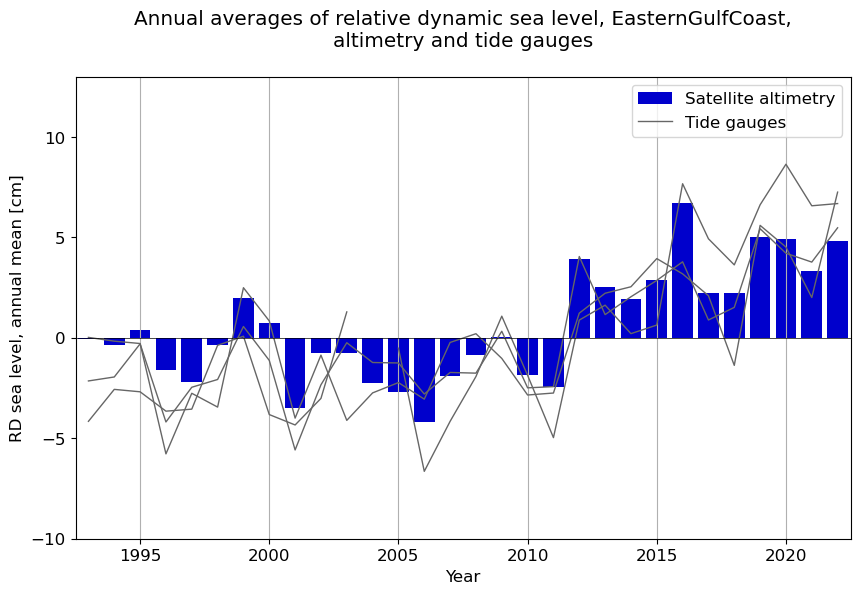

In [3]:
# plot altimetry and tide gauge annual means

curr_time_range_ind = np.logical_and(ds_ERA5_reconstr.pred_year.values >= years_to_predict[0],\
                                     ds_ERA5_reconstr.pred_year.values <= years_to_predict[-1]).nonzero()[0]
SSH_altim_yearavg = ds_ERA5_reconstr.obs_tseries_sortmonth.isel(pred_year=curr_time_range_ind).mean('pred_month')

tgauge_tseries_mask = ~np.isnan(tgauge_tseries)
tgauge_tseries_yearavg = np.empty((tgauge_tseries.shape[0],len(years_to_predict)))
tgauge_tseries_yearavg.fill(np.nan)
for year_count,year in enumerate(years_to_predict):
    in_year_ind = np.logical_and(time_monthly_ERA5 >= np.datetime64(str(year)+'-01-01','ns'),\
                                 time_monthly_ERA5 < np.datetime64(str(year+1)+'-01-01','ns'))\
                                    .nonzero()[0]
    in_year_good = np.nansum(tgauge_tseries_mask[:,in_year_ind],axis=-1)
    tgauge_tseries_yearavg[:,year_count] = np.where(in_year_good > 8,\
                                                    np.nansum(tgauge_tseries_mask[:,in_year_ind]\
                                                              *tgauge_tseries[:,in_year_ind],axis=-1)\
                                                    /in_year_good,\
                                                    np.nan)

plt.rcParams['font.size'] = 12

fig,ax = plt.subplots(1,1,figsize=(10,6))
handles = []
h = ax.bar(years_to_predict,(1.e2)*SSH_altim_yearavg.values,color=(0,0,.8),label='Satellite altimetry')
handles.append(h)
for tgauge_loc_ind in range(tgauge_tseries_yearavg.shape[0]):
    h, = ax.plot(years_to_predict,(1.e2)*tgauge_tseries_yearavg[tgauge_loc_ind,:],\
                 color=(.4,.4,.4),linewidth=1,label='Tide gauges')
handles.append(h)
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([years_to_predict[0]-0.5,years_to_predict[-1]+0.5])
ax.set_ylim([-10,13])
ax.set_xlabel('Year')
ax.set_ylabel('RD sea level, annual mean [cm]')
ax.legend(handles=handles)
ax.set_title(f'Annual averages of relative dynamic sea level, {place_id},\n'\
                +'altimetry and tide gauges\n')
plt.savefig(f'RSL_annmeans_altim_tgauge_{place_id}_{year_range_id}.png')
plt.show()

In [3]:
# ECCO state estimate time series

ds_ECCO_v4r4 = xr.open_mfdataset(join(expanduser('~'),'Downloads','ECCO_V4r4_PODAAC',\
                                          'ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4','*llc0090.nc'),\
                                     compat='override',data_vars='minimal',coords='minimal')
time_v4r4_ind = np.logical_and(ds_ECCO_v4r4.time.values >= np.datetime64(str(years_to_predict[0])+'-01-01','ns'),\
                           ds_ECCO_v4r4.time.values < np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns'))\
                            .nonzero()[0]
SSH_v4r4 = ds_ECCO_v4r4.SSH.isel(time=time_v4r4_ind)
ETAN_v4r4 = ds_ECCO_v4r4.ETAN.isel(time=time_v4r4_ind)


wet_mask_v4 = ds_grid.maskC.isel(k=0)
SSH_v4r4_globmean = ((wet_mask_v4*ds_grid.rA*SSH_v4r4).sum(['i','j','tile'])\
                        /((wet_mask_v4*ds_grid.rA).sum(['i','j','tile']))).values
ETAN_v4r4_globmean = ((wet_mask_v4*ds_grid.rA*ETAN_v4r4).sum(['i','j','tile'])\
                        /((wet_mask_v4*ds_grid.rA).sum(['i','j','tile']))).values

ds_ECCO_v4r5 = xr.open_mfdataset(join(expanduser('~'),'Documents','ECCO',\
                                      'ECCOv4r5','ECCOv4r5_Alpha','ECCOv4r5_Alpha_SSH',\
                                      'V4r5_Alpha_59o00_SSH_mon_mean.nc'))
time_v4r5_ind = np.logical_and(ds_ECCO_v4r5.time.values >= np.datetime64(str(years_to_predict[0])+'-01-01','ns'),\
                           ds_ECCO_v4r5.time.values < np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns'))\
                            .nonzero()[0]
SSH_v4r5 = ds_ECCO_v4r5.SSH.isel(time=time_v4r5_ind)
SSH_v4r5_globmean = ((wet_mask_v4*ds_grid.rA*SSH_v4r5).sum(['i','j','tile'])\
                        /((wet_mask_v4*ds_grid.rA).sum(['i','j','tile']))).values



ds_grid_v5 = xr.open_mfdataset(join(expanduser('~'),'Downloads','ECCO_V5_Drive',\
                                    'Alpha','nctiles_grid','ECCO-GRID-v5.nc'))
ds_ECCO_v5 = xr.open_mfdataset(join(expanduser('~'),'Downloads','ECCO_V5_Drive',\
                                        'Alpha','nctiles_monthly','ETAN','ETAN_*.nc'),\
                                   compat='override',data_vars='minimal',coords='minimal')
time_v5_ind = np.logical_and(ds_ECCO_v5.time.values >= np.datetime64(str(years_to_predict[0])+'-01-01','ns'),\
                           ds_ECCO_v5.time.values < np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns'))\
                            .nonzero()[0]
ETAN_v5 = ds_ECCO_v5.ETAN.isel(time=time_v5_ind)

wet_mask_v5 = ds_grid_v5.maskC.isel(k=0)
ETAN_v5_globmean = ((wet_mask_v5*ds_grid_v5.rA*ETAN_v5).sum(['i','j','tile'])\
                        /((wet_mask_v5*ds_grid_v5.rA).sum(['i','j','tile']))).values

# compute state estimate averages in mask region
area_v4_inregion = 0
area_v5_inregion = 0
SSH_v4r4_inregion = np.zeros((len(time_v4r4_ind),))
ETAN_v4r4_inregion = np.zeros((len(time_v4r4_ind),))
SSH_v4r5_inregion = np.zeros((len(time_v4r5_ind),))
ETAN_v5_inregion = np.zeros((len(time_v5_ind),))
for curr_ind in np.asarray(in_region_ind).transpose():
    curr_ind_dict = {'tile':curr_ind[0],'j':curr_ind[1],'i':curr_ind[2]}
    curr_ind_v5_dict = {'tile':curr_ind[0]*np.ones((3,)).astype('int64'),\
                        'j':np.arange(3*curr_ind[1],3*(curr_ind[1]+1)),\
                        'i':np.arange(3*curr_ind[2],3*(curr_ind[2]+1))}
    area_v4_inregion += (wet_mask_v4*ds_grid.rA).isel(curr_ind_dict).values
    SSH_v4r4_inregion += (wet_mask_v4*ds_grid.rA*SSH_v4r4).isel(curr_ind_dict).values
    ETAN_v4r4_inregion += (wet_mask_v4*ds_grid.rA*ETAN_v4r4).isel(curr_ind_dict).values
    SSH_v4r5_inregion += (wet_mask_v4*ds_grid.rA*SSH_v4r5).isel(curr_ind_dict).values
    
    area_v5_inregion += (wet_mask_v5*ds_grid_v5.rA).isel(curr_ind_v5_dict).sum(['i','j','tile']).values
    ETAN_v5_inregion += (wet_mask_v5*ds_grid_v5.rA*ETAN_v5).isel(curr_ind_v5_dict).sum(['i','j','tile']).values

SSH_v4r4_inregion = SSH_v4r4_inregion/area_v4_inregion
ETAN_v4r4_inregion = ETAN_v4r4_inregion/area_v4_inregion
SSH_v4r5_inregion = SSH_v4r5_inregion/area_v4_inregion
ETAN_v5_inregion = ETAN_v5_inregion/area_v5_inregion

# adjust ETAN to SSH and remove global means
SSH_v5_inregion = ETAN_v5_inregion + (SSH_v4r4_inregion - ETAN_v4r4_inregion)\
                    - (ETAN_v5_globmean + (SSH_v4r4_globmean - ETAN_v4r4_globmean))
SSH_v4r4_inregion -= SSH_v4r4_globmean
SSH_v4r5_inregion -= SSH_v4r5_globmean

# remove time means
SSH_v4r4_inregion -= np.nanmean(SSH_v4r4_inregion)
SSH_v4r5_inregion -= np.nanmean(SSH_v4r5_inregion)
SSH_v5_inregion -= np.nanmean(SSH_v5_inregion)

In [4]:
def seas_cycle_remove(tseries,time):
    tseries_noseason = seasonal_cycle_harmonics(tseries,time,num_harmonics=4,time_axis_num=-1)
    
    return tseries_noseason


def trendline_10yrlp_compute(tseries,edge_handling_opt=1):
    tseries_lp,trendline = bandpass_err_fcn(tseries,axis=-1,delta_dim=365.24/12,\
                                            high_bound=1/(10*365.24),steepness_factor=2,\
                                            trend_handling_opt=1,edge_handling_opt=edge_handling_opt)
    
    return tseries_lp,trendline


def trendline_12molp_compute(tseries,edge_handling_opt=1):
    tseries_lp,trendline = bandpass_err_fcn(tseries,axis=-1,delta_dim=365.24/12,\
                                            high_bound=1/365.24,steepness_factor=2,\
                                            trend_handling_opt=1,edge_handling_opt=edge_handling_opt)
    
    return tseries_lp,trendline


altim_noseas = seas_cycle_remove(SSH_altim,time_monthly)
ERA5_reconstr_noseas = seas_cycle_remove(SSH_ERA5_reconstr,time_monthly)
ECCO_reconstr_noseas = seas_cycle_remove(SSH_ECCO_reconstr,time_monthly)
tgauge_noseas = seas_cycle_remove(tgauge_tseries,time_monthly)
v4r4_noseas = seas_cycle_remove(SSH_v4r4_inregion,time_monthly)
v4r5_noseas = seas_cycle_remove(SSH_v4r5_inregion,time_monthly)
v5_noseas = seas_cycle_remove(SSH_v5_inregion,time_monthly)

altim_10yrlp,altim_trendline = trendline_10yrlp_compute(altim_noseas,edge_handling_opt=0)
ERA5_reconstr_10yrlp,ERA5_reconstr_trendline = trendline_10yrlp_compute(ERA5_reconstr_noseas,edge_handling_opt=0)
ECCO_reconstr_10yrlp,ECCO_reconstr_trendline = trendline_10yrlp_compute(ECCO_reconstr_noseas,edge_handling_opt=0)
tgauge_10yrlp,tgauge_trendline = trendline_10yrlp_compute(tgauge_noseas,edge_handling_opt=0)
v4r4_10yrlp,v4r4_trendline = trendline_10yrlp_compute(v4r4_noseas,edge_handling_opt=0)
v4r5_10yrlp,v4r5_trendline = trendline_10yrlp_compute(v4r5_noseas,edge_handling_opt=0)
v5_10yrlp,v5_trendline = trendline_10yrlp_compute(v5_noseas,edge_handling_opt=0)

altim_12molp,_ = trendline_12molp_compute(altim_noseas)
ERA5_reconstr_12molp,ERA5_reconstr_trendline = trendline_12molp_compute(ERA5_reconstr_noseas,edge_handling_opt=0)
ECCO_reconstr_12molp,ECCO_reconstr_trendline = trendline_12molp_compute(ECCO_reconstr_noseas,edge_handling_opt=0)
tgauge_12molp,tgauge_trendline = trendline_12molp_compute(tgauge_noseas,edge_handling_opt=0)
v4r4_12molp,v4r4_trendline = trendline_12molp_compute(v4r4_noseas,edge_handling_opt=0)
v4r5_12molp,v4r5_trendline = trendline_12molp_compute(v4r5_noseas,edge_handling_opt=0)
v5_12molp,v5_trendline = trendline_12molp_compute(v5_noseas,edge_handling_opt=0)

C:\Users\adelman\Documents\py_functions\filter_functions.py:45: RuntimeWarning: divide by zero encountered in log
  bandpass_filter = 0.5*(special.erf(steepness_factor*(np.log(np.abs(f_vec)) - np.log(low_bound/half_power_adj))) - special.erf(steepness_factor*(np.log(np.abs(f_vec)) - np.log(high_bound*half_power_adj))))


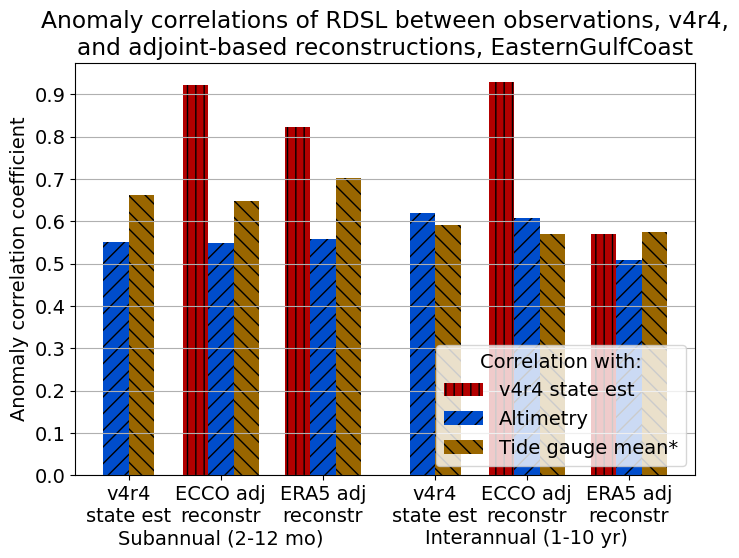

In [5]:
# bar charts of correlations

corr_dict_subannual = {\
    'v4r4-altim':correlation_scalar_scalar_uncert(v4r4_noseas - v4r4_12molp,\
                                                  altim_noseas - altim_12molp)[0][0],\
    'v4r4-tgauge mean':correlation_scalar_scalar_uncert(v4r4_noseas - v4r4_12molp,\
                                                  np.mean(tgauge_noseas - tgauge_12molp,axis=0))[0][0],\
    'ECCO reconstr-v4r4':correlation_scalar_scalar_uncert(ECCO_reconstr_noseas - ECCO_reconstr_12molp,\
                                                  v4r4_noseas - v4r4_12molp)[0][0],\
    'ECCO reconstr-altim':correlation_scalar_scalar_uncert(ECCO_reconstr_noseas - ECCO_reconstr_12molp,\
                                                  altim_noseas - altim_12molp)[0][0],\
    'ECCO reconstr-tgauge mean':correlation_scalar_scalar_uncert(ECCO_reconstr_noseas - ECCO_reconstr_12molp,\
                                                  np.mean(tgauge_noseas - tgauge_12molp,axis=0))[0][0],\
    'ERA5 reconstr-v4r4':correlation_scalar_scalar_uncert(ERA5_reconstr_noseas - ERA5_reconstr_12molp,\
                                                  v4r4_noseas - v4r4_12molp)[0][0],\
    'ERA5 reconstr-altim':correlation_scalar_scalar_uncert(ERA5_reconstr_noseas - ERA5_reconstr_12molp,\
                                                  altim_noseas - altim_12molp)[0][0],\
    'ERA5 reconstr-tgauge mean':correlation_scalar_scalar_uncert(ERA5_reconstr_noseas - ERA5_reconstr_12molp,\
                                                  np.mean(tgauge_noseas - tgauge_12molp,axis=0))[0][0],\
                        }

corr_dict_interannual = {\
    'v4r4-altim':correlation_scalar_scalar_uncert(v4r4_12molp - v4r4_10yrlp,\
                                                  altim_12molp - altim_10yrlp)[0][0],\
    'v4r4-tgauge mean':correlation_scalar_scalar_uncert(v4r4_12molp - v4r4_10yrlp,\
                                                  np.mean(tgauge_12molp - tgauge_10yrlp,axis=0))[0][0],\
    'ECCO reconstr-v4r4':correlation_scalar_scalar_uncert(ECCO_reconstr_12molp - ECCO_reconstr_10yrlp,\
                                                  v4r4_12molp - v4r4_10yrlp)[0][0],\
    'ECCO reconstr-altim':correlation_scalar_scalar_uncert(ECCO_reconstr_12molp - ECCO_reconstr_10yrlp,\
                                                  altim_12molp - altim_10yrlp)[0][0],\
    'ECCO reconstr-tgauge mean':correlation_scalar_scalar_uncert(ECCO_reconstr_12molp - ECCO_reconstr_10yrlp,\
                                                  np.mean(tgauge_12molp - tgauge_10yrlp,axis=0))[0][0],\
    'ERA5 reconstr-v4r4':correlation_scalar_scalar_uncert(ERA5_reconstr_12molp - ERA5_reconstr_10yrlp,\
                                                  v4r4_12molp - v4r4_10yrlp)[0][0],\
    'ERA5 reconstr-altim':correlation_scalar_scalar_uncert(ERA5_reconstr_12molp - ERA5_reconstr_10yrlp,\
                                                  altim_12molp - altim_10yrlp)[0][0],\
    'ERA5 reconstr-tgauge mean':correlation_scalar_scalar_uncert(ERA5_reconstr_12molp - ERA5_reconstr_10yrlp,\
                                                  np.mean(tgauge_12molp - tgauge_10yrlp,axis=0))[0][0],\
                        }

plt.rcParams['font.size'] = 14
fig,ax = plt.subplots(figsize=(8,5.5))
rects = ax.bar(-0.25 + np.array([1,2,4,5]),(corr_dict_subannual['ECCO reconstr-v4r4'],corr_dict_subannual['ERA5 reconstr-v4r4'],\
                                   corr_dict_interannual['ECCO reconstr-v4r4'],corr_dict_interannual['ERA5 reconstr-v4r4']),\
               width=0.25,color=(.7,0,0),hatch='||',label='v4r4 state est')
# ax.bar_label(rects,fmt="%.3f",padding=3)
rects = ax.bar(0 + np.array([-0.025,1,2,2.975,4,5]),(corr_dict_subannual['v4r4-altim'],\
                             corr_dict_subannual['ECCO reconstr-altim'],corr_dict_subannual['ERA5 reconstr-altim'],\
                             corr_dict_interannual['v4r4-altim'],\
                             corr_dict_interannual['ECCO reconstr-altim'],corr_dict_interannual['ERA5 reconstr-altim']),\
               width=0.25,color=(0,.3,.8),hatch='//',label='Altimetry')
# ax.bar_label(rects,fmt="%.3f",padding=3)
rects = ax.bar(0.25 + np.array([-0.025,1,2,2.975,4,5]),(corr_dict_subannual['v4r4-tgauge mean'],\
                                   corr_dict_subannual['ECCO reconstr-tgauge mean'],corr_dict_subannual['ERA5 reconstr-tgauge mean'],\
                                                       corr_dict_interannual['v4r4-tgauge mean'],\
                                   corr_dict_interannual['ECCO reconstr-tgauge mean'],corr_dict_interannual['ERA5 reconstr-tgauge mean']),\
               width=0.25,color=(.6,.4,0),hatch="\\\\",label='Tide gauge mean*')
# ax.bar_label(rects,fmt="%.3f",padding=3)
ax.set_xticks((.1,1,2,3.1,4,5),labels=('v4r4\nstate est','ECCO adj\nreconstr\nSubannual (2-12 mo)','ERA5 adj\nreconstr',\
                                       'v4r4\nstate est','ECCO adj\nreconstr\nInterannual (1-10 yr)','ERA5 adj\nreconstr'))
ax.set_yticks(np.arange(0,1,0.1))
ax.set_ylabel('Anomaly correlation coefficient')
plt.subplots_adjust(top=0.9,bottom=0.15)
ax.grid(axis='y')
ax.legend(loc='lower right',title='Correlation with:')
ax.set_title('Anomaly correlations of RDSL between observations, v4r4,\nand adjoint-based reconstructions, '+place_id)
plt.savefig(f'RSL_corr_obs_stateest_reconstr_{place_id}_{year_range_id}.png')
plt.show()

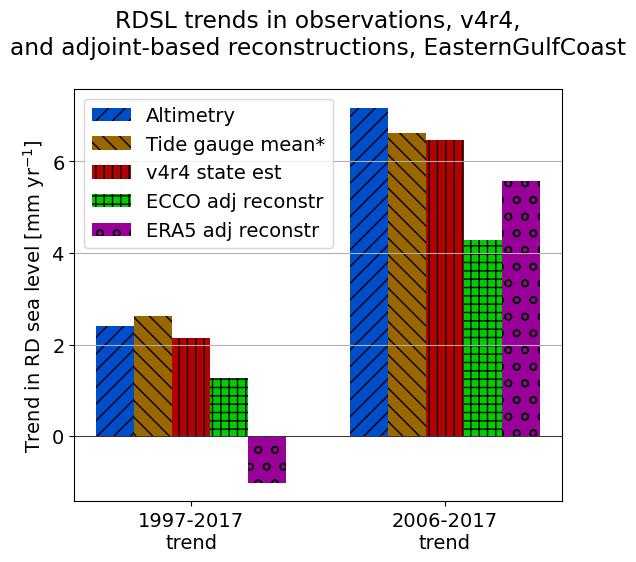

In [6]:
year_first_subset = 2006
year_last_subset = 2017
year_range_subset_id = str(year_first_subset)+"_"+str(year_last_subset)
subset_time_ind = np.logical_and(time_monthly >= np.datetime64(str(year_first_subset)+'-01-01','ns'),\
                                 time_monthly < np.datetime64(str(year_last_subset+1)+'-01-01','ns')).nonzero()[0]

altim_trend_peryr_subset = trend_compute(altim_noseas[subset_time_ind],delta_dim=1/12)[0]
ERA5_reconstr_trend_peryr_subset = trend_compute(ERA5_reconstr_noseas[subset_time_ind],delta_dim=1/12)[0]
ECCO_reconstr_trend_peryr_subset = trend_compute(ECCO_reconstr_noseas[subset_time_ind],delta_dim=1/12)[0]
tgauge_mean_trend_peryr_subset = trend_compute(np.mean(tgauge_noseas,axis=0)[subset_time_ind],delta_dim=1/12)[0]
v4r4_trend_peryr_subset = trend_compute(v4r4_noseas[subset_time_ind],delta_dim=1/12)[0]

altim_trend_peryr = trend_compute(altim_noseas,delta_dim=1/12)[0]
ERA5_reconstr_trend_peryr = trend_compute(ERA5_reconstr_noseas,delta_dim=1/12)[0]
ECCO_reconstr_trend_peryr = trend_compute(ECCO_reconstr_noseas,delta_dim=1/12)[0]
tgauge_mean_trend_peryr = trend_compute(np.mean(tgauge_noseas,axis=0),delta_dim=1/12)[0]
v4r4_trend_peryr = trend_compute(v4r4_noseas,delta_dim=1/12)[0]

plt.rcParams['font.size'] = 14
fig,ax = plt.subplots(figsize=(7.5,5.5))
rects = ax.bar(-0.3 + np.array([0,1]),(1.e3)*np.array([altim_trend_peryr,altim_trend_peryr_subset]),\
               width=0.15,color=(0,.3,.8),hatch='//',label='Altimetry')
rects = ax.bar(-0.15 + np.array([0,1]),(1.e3)*np.array([tgauge_mean_trend_peryr,tgauge_mean_trend_peryr_subset]),\
               width=0.15,color=(.6,.4,0),hatch="\\\\",label='Tide gauge mean*')
rects = ax.bar(0 + np.array([0,1]),(1.e3)*np.array([v4r4_trend_peryr,v4r4_trend_peryr_subset]),\
               width=0.15,color=(.7,0,0),hatch='||',label='v4r4 state est')
rects = ax.bar(0.15 + np.array([0,1]),(1.e3)*np.array([ECCO_reconstr_trend_peryr,ECCO_reconstr_trend_peryr_subset]),\
               width=0.15,color=(0,.8,0),hatch='++',label='ECCO adj reconstr')
rects = ax.bar(0.3 + np.array([0,1]),(1.e3)*np.array([ERA5_reconstr_trend_peryr,ERA5_reconstr_trend_peryr_subset]),\
               width=0.15,color=(.6,0,.6),hatch='o',label='ERA5 adj reconstr')
ax.set_xticks((0,1),labels=(year_range_id.replace("_","-")+'\ntrend',year_range_subset_id.replace("_","-")+'\ntrend'))
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.set_ylabel('Trend in RD sea level [mm yr$^{-1}$]')
plt.subplots_adjust(top=0.85,bottom=0.1,left=0.15,right=0.8)
ax.grid(axis='y')
ax.legend()
ax.set_title('RDSL trends in observations, v4r4,\nand adjoint-based reconstructions, '+place_id+'\n')
plt.savefig(f'RSL_trend_obs_stateest_reconstr_{place_id}_{year_range_subset_id}_subset_{year_range_id}.png')
plt.show()

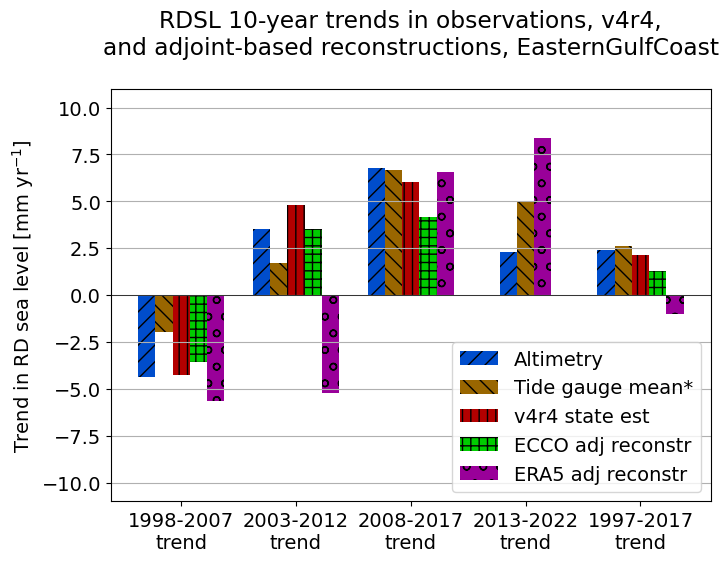

In [7]:
# plot 10-year trends, including for a range after years_to_predict

trend_first_years = [1998,2003,2008,2013,1997]
trend_last_years = [2007,2012,2017,2022,2017]

ERA5_reconstr_times = ds_ERA5_reconstr.pred_time.values.transpose().flatten()
curr_ERA5_reconstr = ds_ERA5_reconstr.reconstr_total.values.transpose().flatten()
curr_altim = ds_ERA5_reconstr.obs_tseries_sortmonth.values.transpose().flatten()

curr_years_to_predict = ds_ERA5_reconstr.pred_year.values
curr_tgauge_tseries = np.empty((len(tgauge_loc_list),12*len(curr_years_to_predict)))
for tgauge_count,tgauge_loc in enumerate(tgauge_loc_list):
    # read tide gauge data and apply corrections (IB correction, remove global mean sea level)
    curr_datetime,curr_tseries = tgauge_SSH_read_correct(tgauge_loc,years_to_predict=curr_years_to_predict)

    for curr_time_count,curr_time in enumerate(ERA5_reconstr_times):
        curr_time_ind = (np.abs(curr_datetime - curr_time) <= np.timedelta64(10,'D')).nonzero()[0][0]
        curr_tgauge_tseries[tgauge_count,curr_time_count] = curr_tseries[curr_time_ind]

curr_tgauge_tseries -= np.nanmean(curr_tgauge_tseries,axis=-1,keepdims=True)


curr_altim_noseas = seas_cycle_remove(curr_altim,ERA5_reconstr_times)
curr_ERA5_reconstr_noseas = seas_cycle_remove(curr_ERA5_reconstr,ERA5_reconstr_times)
curr_tgauge_noseas = seas_cycle_remove(curr_tgauge_tseries,ERA5_reconstr_times)


plt.rcParams['font.size'] = 14
fig,ax = plt.subplots(figsize=(8,5.5))
altim_trends_peryr = np.array([])
tgauge_mean_trends_peryr = np.array([])
v4r4_trends_peryr = np.array([])
ECCO_reconstr_trends_peryr = np.array([])
ERA5_reconstr_trends_peryr = np.array([])
curr_labels = []
for curr_year_first,curr_year_last in zip(trend_first_years,trend_last_years):
    curr_year_range_id = str(curr_year_first)+'-'+str(curr_year_last)
    subset_ECCO_time_ind = np.logical_and(time_monthly >= np.datetime64(str(curr_year_first)+'-01-01','ns'),\
                                          time_monthly < np.datetime64(str(curr_year_last+1)+'-01-01','ns')).nonzero()[0]
    subset_ERA5_time_ind = np.logical_and(ERA5_reconstr_times >= np.datetime64(str(curr_year_first)+'-01-01','ns'),\
                                          ERA5_reconstr_times < np.datetime64(str(curr_year_last+1)+'-01-01','ns')).nonzero()[0]
    
    altim_trends_peryr = np.append(altim_trends_peryr,\
                                   trend_compute(curr_altim_noseas[subset_ERA5_time_ind],delta_dim=1/12)[0])
    ERA5_reconstr_trends_peryr = np.append(ERA5_reconstr_trends_peryr,\
                                           trend_compute(curr_ERA5_reconstr_noseas[subset_ERA5_time_ind],delta_dim=1/12)[0])
    tgauge_mean_trends_peryr = np.append(tgauge_mean_trends_peryr,\
                                         trend_compute(np.mean(curr_tgauge_noseas,axis=0)[subset_ERA5_time_ind],delta_dim=1/12)[0])
    if curr_year_last < 2018:
        ECCO_reconstr_trends_peryr = np.append(ECCO_reconstr_trends_peryr,\
                                               trend_compute(ECCO_reconstr_noseas[subset_ECCO_time_ind],delta_dim=1/12)[0])
        v4r4_trends_peryr = np.append(v4r4_trends_peryr,\
                                      trend_compute(v4r4_noseas[subset_ECCO_time_ind],delta_dim=1/12)[0])
    curr_labels.append(curr_year_range_id+'\ntrend')
rects = ax.bar(-0.3 + np.array([0,1,2,3.15,4]),(1.e3)*altim_trends_peryr,\
               width=0.15,color=(0,.3,.8),hatch='//',label='Altimetry')
rects = ax.bar(-0.15 + np.array([0,1,2,3.15,4]),(1.e3)*tgauge_mean_trends_peryr,\
               width=0.15,color=(.6,.4,0),hatch="\\\\",label='Tide gauge mean*')
rects = ax.bar(0 + np.array([0,1,2,4]),(1.e3)*v4r4_trends_peryr,\
               width=0.15,color=(.7,0,0),hatch='||',label='v4r4 state est')
rects = ax.bar(0.15 + np.array([0,1,2,4]),(1.e3)*ECCO_reconstr_trends_peryr,\
               width=0.15,color=(0,.8,0),hatch='++',label='ECCO adj reconstr')
rects = ax.bar(0.3 + np.array([0,1,2,2.85,4]),(1.e3)*ERA5_reconstr_trends_peryr,\
               width=0.15,color=(.6,0,.6),hatch='o',label='ERA5 adj reconstr')
ax.set_xticks(np.arange(0,len(trend_first_years)),labels=curr_labels)
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.set_ylim([-11,11])
ax.set_ylabel('Trend in RD sea level [mm yr$^{-1}$]')
plt.subplots_adjust(top=0.85,bottom=0.1,left=0.15)
ax.grid(axis='y')
ax.legend()
ax.set_title('RDSL 10-year trends in observations, v4r4,\nand adjoint-based reconstructions, '+place_id+'\n')
plt.savefig(f'RSL_10yrtrends_obs_stateest_reconstr_{place_id}_{year_range_id}.png')
plt.show()

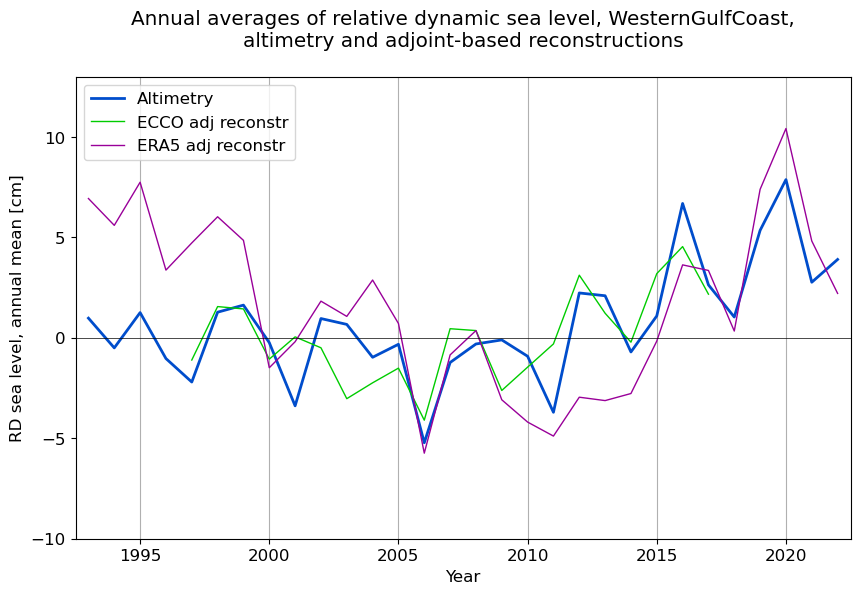

In [13]:
# # plot altimetry and tide gauge annual means

# ECCO_years_to_predict = np.arange(1997,2018)
# curr_time_range_ind = np.logical_and(ds_ECCO_reconstr.pred_year.values >= ECCO_years_to_predict[0],\
#                                      ds_ECCO_reconstr.pred_year.values <= ECCO_years_to_predict[-1]).nonzero()[0]
# ECCO_reconstr_yearavg = ds_ECCO_reconstr.reconstr_total.isel(pred_year=curr_time_range_ind).mean('pred_month')
# ECCO_reconstr_yearavg -= ECCO_reconstr_yearavg.mean('pred_year')

# ERA5_years_to_predict = np.arange(1993,2023)
# curr_time_range_ind = np.logical_and(ds_ERA5_reconstr.pred_year.values >= ERA5_years_to_predict[0],\
#                                      ds_ERA5_reconstr.pred_year.values <= ERA5_years_to_predict[-1]).nonzero()[0]
# SSH_altim_yearavg = ds_ERA5_reconstr.obs_tseries_sortmonth.isel(pred_year=curr_time_range_ind).mean('pred_month')
# ERA5_reconstr_yearavg = ds_ERA5_reconstr.reconstr_total.isel(pred_year=curr_time_range_ind).mean('pred_month')
# ECCO_in_ERA5_time_range_ind = np.logical_and(ds_ERA5_reconstr.pred_year.values[curr_time_range_ind] >= ECCO_years_to_predict[0],\
#                                              ds_ERA5_reconstr.pred_year.values[curr_time_range_ind] <= ECCO_years_to_predict[-1]).nonzero()[0]
# SSH_altim_yearavg -= SSH_altim_yearavg.isel(pred_year=ECCO_in_ERA5_time_range_ind)\
#                                         .mean('pred_year')
# ERA5_reconstr_yearavg -= ERA5_reconstr_yearavg.isel(pred_year=ECCO_in_ERA5_time_range_ind)\
#                                         .mean('pred_year')

# curr_year_range_id = str(ERA5_years_to_predict[0])+'-'+str(ERA5_years_to_predict[-1])

# plt.rcParams['font.size'] = 12

# fig,ax = plt.subplots(1,1,figsize=(10,6))
# handles = []
# ax.plot(ERA5_years_to_predict,(1.e2)*SSH_altim_yearavg,\
#                  color=(0,.3,.8),linewidth=2,label='Altimetry')
# ax.plot(ECCO_years_to_predict,(1.e2)*ECCO_reconstr_yearavg,\
#                  color=(0,.8,0),linewidth=1,label='ECCO adj reconstr')
# ax.plot(ERA5_years_to_predict,(1.e2)*ERA5_reconstr_yearavg,\
#                  color=(.6,0,.6),linewidth=1,label='ERA5 adj reconstr')
# ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
# ax.grid(axis='x')
# ax.set_xlim([ERA5_years_to_predict[0]-0.5,ERA5_years_to_predict[-1]+0.5])
# ax.set_ylim([-10,13])
# ax.set_xlabel('Year')
# ax.set_ylabel('RD sea level, annual mean [cm]')
# ax.legend()
# ax.set_title(f'Annual averages of relative dynamic sea level, {place_id},\n'\
#                 +'altimetry and adjoint-based reconstructions\n')
# plt.savefig(f'RSL_annmeans_altim_ECCO_ERA5_reconstr_{place_id}_{curr_year_range_id.replace("-","_")}.png')
# plt.show()

In [8]:
# ECCO state estimate time series (complete)

ds_ECCO_v4r4 = xr.open_mfdataset(join(expanduser('~'),'Downloads','ECCO_V4r4_PODAAC',\
                                          'ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4','*llc0090.nc'),\
                                     compat='override',data_vars='minimal',coords='minimal')
curr_SSH_v4r4 = ds_ECCO_v4r4.SSH


wet_mask_v4 = ds_grid.maskC.isel(k=0)
curr_SSH_v4r4_globmean = ((wet_mask_v4*ds_grid.rA*curr_SSH_v4r4).sum(['i','j','tile'])\
                            /((wet_mask_v4*ds_grid.rA).sum(['i','j','tile']))).values


# compute state estimate averages in mask region
area_v4_inregion = 0
curr_SSH_v4r4_inregion = np.zeros((len(ds_ECCO_v4r4.time.values),))
for curr_ind in np.asarray(in_region_ind).transpose():
    curr_ind_dict = {'tile':curr_ind[0],'j':curr_ind[1],'i':curr_ind[2]}
    area_v4_inregion += (wet_mask_v4*ds_grid.rA).isel(curr_ind_dict).values
    curr_SSH_v4r4_inregion += (wet_mask_v4*ds_grid.rA*curr_SSH_v4r4).isel(curr_ind_dict).values

curr_SSH_v4r4_inregion = curr_SSH_v4r4_inregion/area_v4_inregion

# remove global means
curr_SSH_v4r4_inregion -= curr_SSH_v4r4_globmean

# remove time means
curr_SSH_v4r4_inregion -= np.nanmean(curr_SSH_v4r4_inregion)

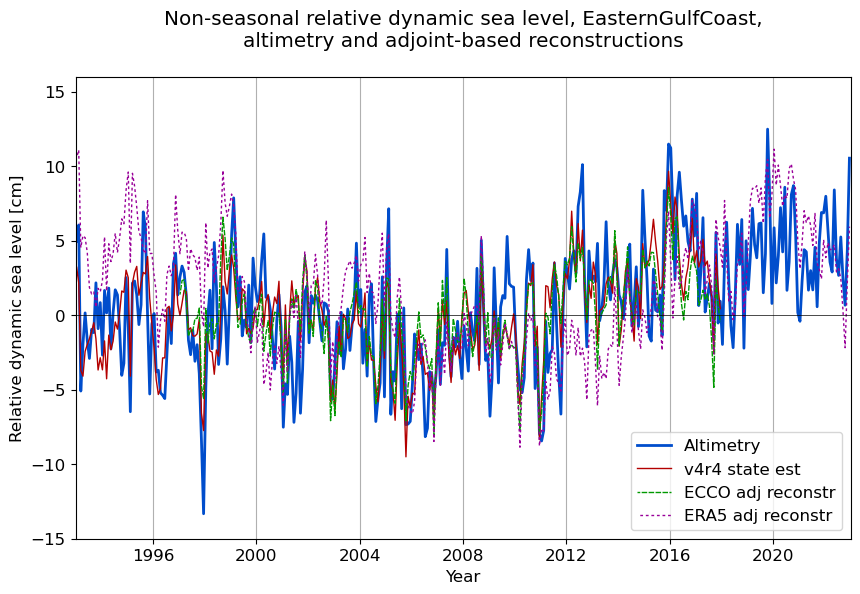

In [9]:
# plot altimetry and adj reconstructions, seas cycle removed

ERA5_years_to_predict = np.arange(1993,2023)
curr_time_range_ind = np.logical_and(ds_ERA5_reconstr.pred_year.values >= ERA5_years_to_predict[0],\
                                     ds_ERA5_reconstr.pred_year.values <= ERA5_years_to_predict[-1]).nonzero()[0]
curr_ERA5_time_monthly = ds_ERA5_reconstr.pred_time.isel(pred_year=curr_time_range_ind)\
                                    .transpose('pred_year','pred_month').values.flatten()
curr_altim = ds_ERA5_reconstr.obs_tseries_sortmonth.isel(pred_year=curr_time_range_ind)\
                                  .transpose('pred_year','pred_month').values.flatten()
curr_ERA5_reconstr = ds_ERA5_reconstr.reconstr_total.isel(pred_year=curr_time_range_ind)\
                                                  .transpose('pred_year','pred_month').values.flatten()
curr_altim_noseas = seas_cycle_remove(curr_altim,curr_ERA5_time_monthly)
curr_ERA5_reconstr_noseas = seas_cycle_remove(curr_ERA5_reconstr,curr_ERA5_time_monthly)

ECCO_years_to_predict = np.arange(1997,2018)
ECCO_in_ERA5_time_range_ind = np.logical_and(curr_ERA5_time_monthly >= np.datetime64(str(ECCO_years_to_predict[0])+'-01-01','ns'),\
                                             curr_ERA5_time_monthly <= np.datetime64(str(ECCO_years_to_predict[-1]+1)+'-01-01','ns')).nonzero()[0]
curr_altim_noseas -= np.nanmean(curr_altim_noseas[ECCO_in_ERA5_time_range_ind])
curr_ERA5_reconstr_noseas -= np.nanmean(curr_ERA5_reconstr_noseas[ECCO_in_ERA5_time_range_ind])
ECCO_time_range_ind = np.logical_and(time_monthly >= np.datetime64(str(ECCO_years_to_predict[0])+'-01-01','ns'),\
                                     time_monthly <= np.datetime64(str(ECCO_years_to_predict[-1]+1)+'-01-01','ns')).nonzero()[0]
curr_ECCO_reconstr_noseas = ECCO_reconstr_noseas[ECCO_time_range_ind]
curr_ECCO_reconstr_noseas -= np.nanmean(curr_ECCO_reconstr_noseas)

curr_v4r4_noseas = seas_cycle_remove(curr_SSH_v4r4_inregion,ds_ECCO_v4r4.time.values)
curr_v4r4_noseas -= np.nanmean(curr_v4r4_noseas[48:])

curr_year_range_id = str(ERA5_years_to_predict[0])+'-'+str(ERA5_years_to_predict[-1])

plt.rcParams['font.size'] = 12

fig,ax = plt.subplots(1,1,figsize=(10,6))
handles = []
ax.plot(curr_ERA5_time_monthly,(1.e2)*curr_altim_noseas,\
                 color=(0,.3,.8),linewidth=2,label='Altimetry')
ax.plot(ds_ECCO_v4r4.time.values,(1.e2)*curr_v4r4_noseas,\
                 color=(.7,0,0),linewidth=1,label='v4r4 state est')
ax.plot(time_monthly[ECCO_time_range_ind],(1.e2)*curr_ECCO_reconstr_noseas,\
                 color=(0,.6,0),linewidth=1,linestyle=(2,(4,1)),label='ECCO adj reconstr')
ax.plot(curr_ERA5_time_monthly,(1.e2)*curr_ERA5_reconstr_noseas,\
                 color=(.6,0,.6),linewidth=1,linestyle=(2,(2,2)),label='ERA5 adj reconstr')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64(str(ERA5_years_to_predict[0])+'-01-01','ns'),\
             np.datetime64(str(ERA5_years_to_predict[-1]+1)+'-01-01','ns')])
ax.set_ylim([-15,16])
ax.set_xlabel('Year')
ax.set_ylabel('Relative dynamic sea level [cm]')
ax.legend()
ax.set_title(f'Non-seasonal relative dynamic sea level, {place_id},\n'\
                +'altimetry and adjoint-based reconstructions\n')
plt.savefig(f'RSL_noseas_altim_stateest_ECCO_ERA5_reconstr_{place_id}_{curr_year_range_id.replace("-","_")}.png')
plt.show()

C:\Users\adelman\Documents\py_functions\filter_functions.py:45: RuntimeWarning: divide by zero encountered in log
  bandpass_filter = 0.5*(special.erf(steepness_factor*(np.log(np.abs(f_vec)) - np.log(low_bound/half_power_adj))) - special.erf(steepness_factor*(np.log(np.abs(f_vec)) - np.log(high_bound*half_power_adj))))


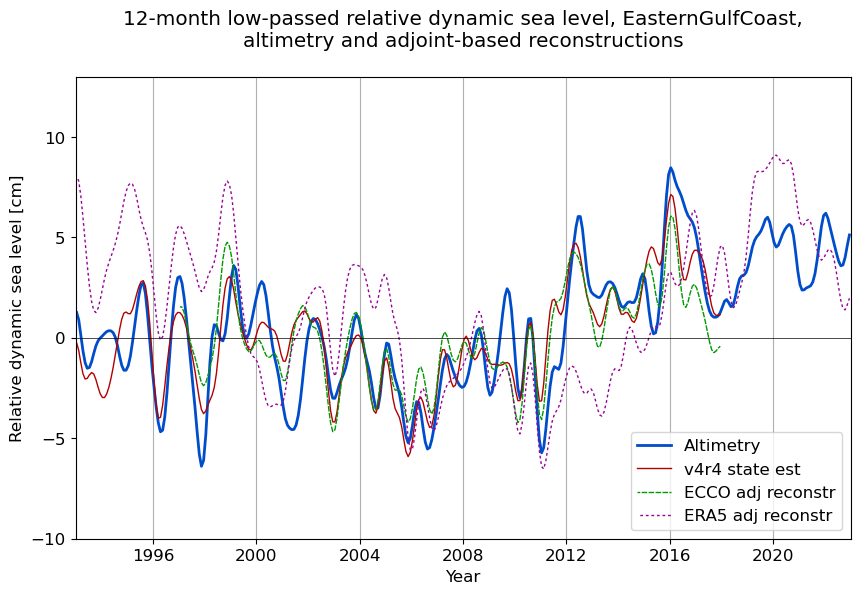

In [10]:
# plot altimetry and adj reconstructions, seas cycle removed, 12 month low-passed

ERA5_years_to_predict = np.arange(1993,2023)
curr_time_range_ind = np.logical_and(ds_ERA5_reconstr.pred_year.values >= ERA5_years_to_predict[0],\
                                     ds_ERA5_reconstr.pred_year.values <= ERA5_years_to_predict[-1]).nonzero()[0]
curr_ERA5_time_monthly = ds_ERA5_reconstr.pred_time.isel(pred_year=curr_time_range_ind)\
                                    .transpose('pred_year','pred_month').values.flatten()


curr_altim_12molp,_ = trendline_12molp_compute(curr_altim_noseas,edge_handling_opt=0)
curr_ERA5_reconstr_12molp,_ = trendline_12molp_compute(curr_ERA5_reconstr_noseas,edge_handling_opt=0)
ECCO_years_to_predict = np.arange(1997,2018)
ECCO_in_ERA5_time_range_ind = np.logical_and(curr_ERA5_time_monthly >= np.datetime64(str(ECCO_years_to_predict[0])+'-01-01','ns'),\
                                             curr_ERA5_time_monthly <= np.datetime64(str(ECCO_years_to_predict[-1]+1)+'-01-01','ns')).nonzero()[0]
curr_altim_12molp -= np.nanmean(curr_altim_12molp[ECCO_in_ERA5_time_range_ind])
curr_ERA5_reconstr_12molp -= np.nanmean(curr_ERA5_reconstr_12molp[ECCO_in_ERA5_time_range_ind])
ECCO_time_range_ind = np.logical_and(time_monthly >= np.datetime64(str(ECCO_years_to_predict[0])+'-01-01','ns'),\
                                     time_monthly <= np.datetime64(str(ECCO_years_to_predict[-1]+1)+'-01-01','ns')).nonzero()[0]
curr_ECCO_reconstr_12molp = ECCO_reconstr_12molp[ECCO_time_range_ind]
curr_ECCO_reconstr_12molp -= np.nanmean(curr_ECCO_reconstr_12molp)

curr_v4r4_12molp,_ = trendline_12molp_compute(curr_v4r4_noseas,edge_handling_opt=0)
curr_v4r4_12molp -= np.nanmean(curr_v4r4_12molp[48:])

curr_year_range_id = str(ERA5_years_to_predict[0])+'-'+str(ERA5_years_to_predict[-1])

plt.rcParams['font.size'] = 12

fig,ax = plt.subplots(1,1,figsize=(10,6))
handles = []
ax.plot(curr_ERA5_time_monthly,(1.e2)*curr_altim_12molp,\
                 color=(0,.3,.8),linewidth=2,label='Altimetry')
ax.plot(ds_ECCO_v4r4.time.values,(1.e2)*curr_v4r4_12molp,\
                 color=(.7,0,0),linewidth=1,label='v4r4 state est')
ax.plot(time_monthly[ECCO_time_range_ind],(1.e2)*curr_ECCO_reconstr_12molp,\
                 color=(0,.6,0),linewidth=1,linestyle=(2,(4,1)),label='ECCO adj reconstr')
ax.plot(curr_ERA5_time_monthly,(1.e2)*curr_ERA5_reconstr_12molp,\
                 color=(.6,0,.6),linewidth=1,linestyle=(2,(2,2)),label='ERA5 adj reconstr')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.grid(axis='x')
ax.set_xlim([np.datetime64(str(ERA5_years_to_predict[0])+'-01-01','ns'),\
             np.datetime64(str(ERA5_years_to_predict[-1]+1)+'-01-01','ns')])
ax.set_ylim([-10,13])
ax.set_xlabel('Year')
ax.set_ylabel('Relative dynamic sea level [cm]')
ax.legend()
ax.set_title(f'12-month low-passed relative dynamic sea level, {place_id},\n'\
                +'altimetry and adjoint-based reconstructions\n')
plt.savefig(f'RSL_12molp_altim_stateest_ECCO_ERA5_reconstr_{place_id}_{curr_year_range_id.replace("-","_")}.png')
plt.show()

In [ ]:
# re-do 10 year low-pass with edge_handling_opt=1
altim_10yrlp,altim_trendline = trendline_10yrlp_compute(altim_noseas)
ERA5_reconstr_10yrlp,ERA5_reconstr_trendline = trendline_10yrlp_compute(ERA5_reconstr_noseas)
ECCO_reconstr_10yrlp,ECCO_reconstr_trendline = trendline_10yrlp_compute(ECCO_reconstr_noseas)
tgauge_10yrlp,tgauge_trendline = trendline_10yrlp_compute(tgauge_noseas)
v4r4_10yrlp,v4r4_trendline = trendline_10yrlp_compute(v4r4_noseas)
v4r5_10yrlp,v4r5_trendline = trendline_10yrlp_compute(v4r5_noseas)
v5_10yrlp,v5_trendline = trendline_10yrlp_compute(v5_noseas)

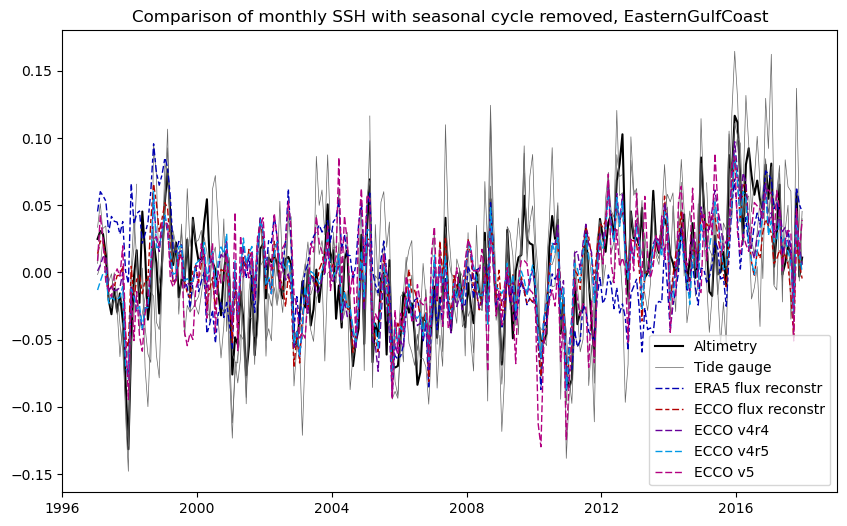

In [6]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
handles = []
h, = ax.plot(time_monthly,altim_noseas,color=(0,0,0),linewidth=1.5,label='Altimetry')
handles.append(h)
for tgauge_count,curr_tseries in enumerate(tgauge_noseas):
    h, = ax.plot(time_monthly,curr_tseries,color=(.4,.4,.4),linewidth=0.5,label='Tide gauge')
    if tgauge_count == 0:
        handles.append(h)
h, = ax.plot(time_monthly,ERA5_reconstr_noseas,color=(0,0,.7),linewidth=1,linestyle=(0,(5,2,3,2)),\
            label='ERA5 flux reconstr')
handles.append(h)
h, = ax.plot(time_monthly,ECCO_reconstr_noseas,color=(.7,0,0),linewidth=1,linestyle=(0,(5,2,3,2)),\
            label='ECCO flux reconstr')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_noseas,color=(.4,0,.6),linewidth=1,linestyle=(0,(5,2)),label='ECCO v4r4')
handles.append(h)
h, = ax.plot(time_monthly,v4r5_noseas,color=(0,.6,.9),linewidth=1,linestyle=(0,(5,2)),label='ECCO v4r5')
handles.append(h)
h, = ax.plot(time_monthly,v5_noseas,color=(.7,0,.5),linewidth=1,linestyle=(0,(5,2)),label='ECCO v5')
handles.append(h)
ax.set_title('Comparison of monthly SSH with seasonal cycle removed, '+place_id)
ax.legend(handles=handles)
plt.show()

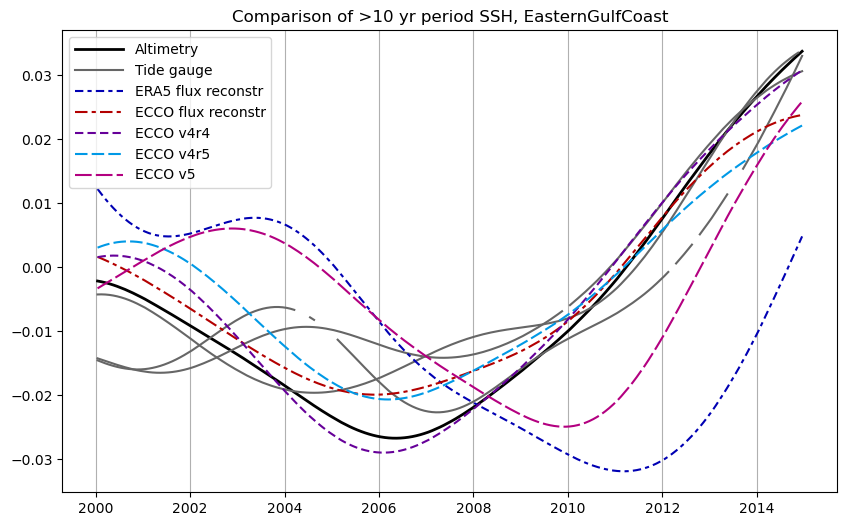

In [7]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
handles = []
h, = ax.plot(time_monthly,altim_10yrlp,color=(0,0,0),linewidth=2,label='Altimetry')
handles.append(h)
for tgauge_count,curr_tseries in enumerate(tgauge_10yrlp):
    h, = ax.plot(time_monthly,curr_tseries,color=(.4,.4,.4),linewidth=1.5,label='Tide gauge')
    if tgauge_count == 0:
        handles.append(h)
h, = ax.plot(time_monthly,ERA5_reconstr_10yrlp,color=(0,0,.7),linewidth=1.5,linestyle=(0,(4,2,2,2)),\
            label='ERA5 flux reconstr')
handles.append(h)
h, = ax.plot(time_monthly,ECCO_reconstr_10yrlp,color=(.7,0,0),linewidth=1.5,linestyle=(0,(6,2,2,2)),\
            label='ECCO flux reconstr')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_10yrlp,color=(.4,0,.6),linewidth=1.5,linestyle=(0,(4,2)),label='ECCO v4r4')
handles.append(h)
h, = ax.plot(time_monthly,v4r5_10yrlp,color=(0,.6,.9),linewidth=1.5,linestyle=(0,(6,2)),label='ECCO v4r5')
handles.append(h)
h, = ax.plot(time_monthly,v5_10yrlp,color=(.7,0,.5),linewidth=1.5,linestyle=(0,(8,2)),label='ECCO v5')
handles.append(h)
ax.grid(axis='x')
ax.set_title('Comparison of >10 yr period SSH, '+place_id)
ax.legend(handles=handles,handlelength=3.5)
plt.savefig(f'RSL_tseries_obs_stateest_reconstr_10yrlp_{place_id}_{year_range_id}.png')
plt.show()

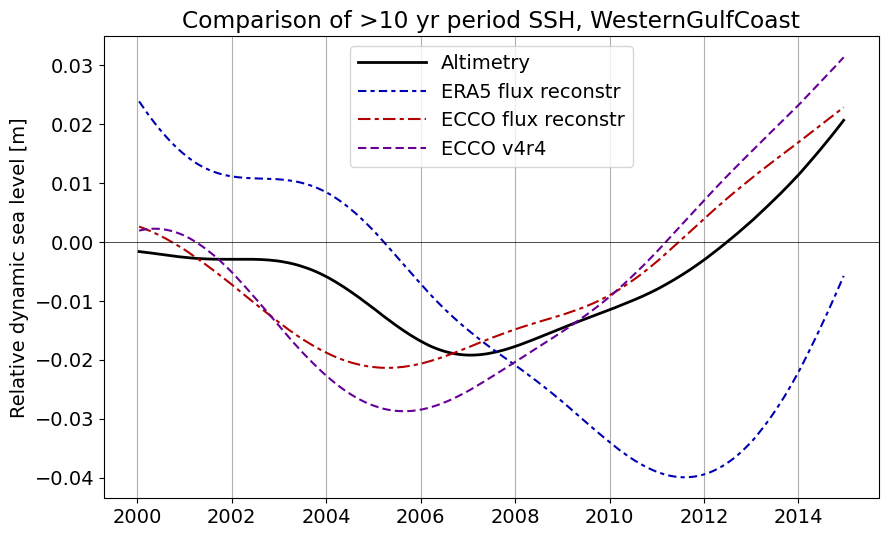

In [7]:
plt.rcParams['font.size'] = 14
fig,ax = plt.subplots(1,1,figsize=(10,6))
handles = []
h, = ax.plot(time_monthly,altim_10yrlp,color=(0,0,0),linewidth=2,label='Altimetry')
handles.append(h)
h, = ax.plot(time_monthly,ERA5_reconstr_10yrlp,color=(0,0,.7),linewidth=1.5,linestyle=(0,(4,2,2,2)),\
            label='ERA5 flux reconstr')
handles.append(h)
h, = ax.plot(time_monthly,ECCO_reconstr_10yrlp,color=(.7,0,0),linewidth=1.5,linestyle=(0,(6,2,2,2)),\
            label='ECCO flux reconstr')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_10yrlp,color=(.4,0,.6),linewidth=1.5,linestyle=(0,(4,2)),label='ECCO v4r4')
handles.append(h)
ax.grid(axis='x')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.set_ylabel('Relative dynamic sea level [m]')
ax.set_title('Comparison of >10 yr period SSH, '+place_id)
ax.legend(handles=handles,handlelength=3.5)
plt.savefig(f'RSL_tseries_altim_v4r4_reconstr_10yrlp_{place_id}_{year_range_id}.png')
plt.show()

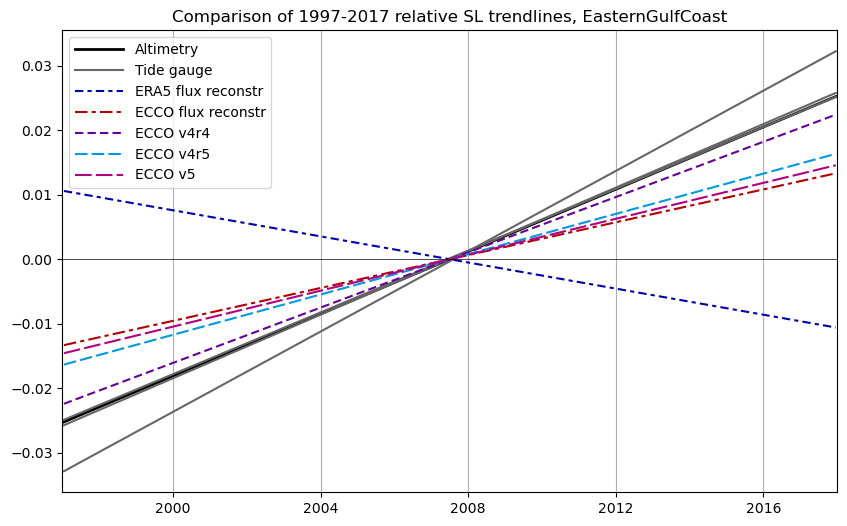

In [8]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
handles = []
h, = ax.plot(time_monthly,altim_trendline,color=(0,0,0),linewidth=2,label='Altimetry')
handles.append(h)
for tgauge_count,curr_tseries in enumerate(tgauge_trendline):
    h, = ax.plot(time_monthly,curr_tseries,color=(.4,.4,.4),linewidth=1.5,label='Tide gauge')
    if tgauge_count == 0:
        handles.append(h)
h, = ax.plot(time_monthly,ERA5_reconstr_trendline,color=(0,0,.7),linewidth=1.5,linestyle=(0,(4,2,2,2)),\
            label='ERA5 flux reconstr')
handles.append(h)
h, = ax.plot(time_monthly,ECCO_reconstr_trendline,color=(.7,0,0),linewidth=1.5,linestyle=(0,(6,2,2,2)),\
            label='ECCO flux reconstr')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_trendline,color=(.4,0,.6),linewidth=1.5,linestyle=(0,(4,2)),label='ECCO v4r4')
handles.append(h)
h, = ax.plot(time_monthly,v4r5_trendline,color=(0,.6,.9),linewidth=1.5,linestyle=(0,(6,2)),label='ECCO v4r5')
handles.append(h)
h, = ax.plot(time_monthly,v5_trendline,color=(.7,0,.5),linewidth=1.5,linestyle=(0,(8,2)),label='ECCO v5')
handles.append(h)
ax.set_xlim(np.datetime64(str(years_to_predict[0])+'-01-01','ns'),\
            np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns'))
ax.grid(axis='x')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.set_title('Comparison of '+year_range_id.replace('_','-')+' relative SL trendlines, '+place_id)
ax.legend(handles=handles,handlelength=3.5)
# plt.savefig(f'RSL_tseries_obs_stateest_reconstr_trendlines_{place_id}_{year_range_id}.png')
plt.show()

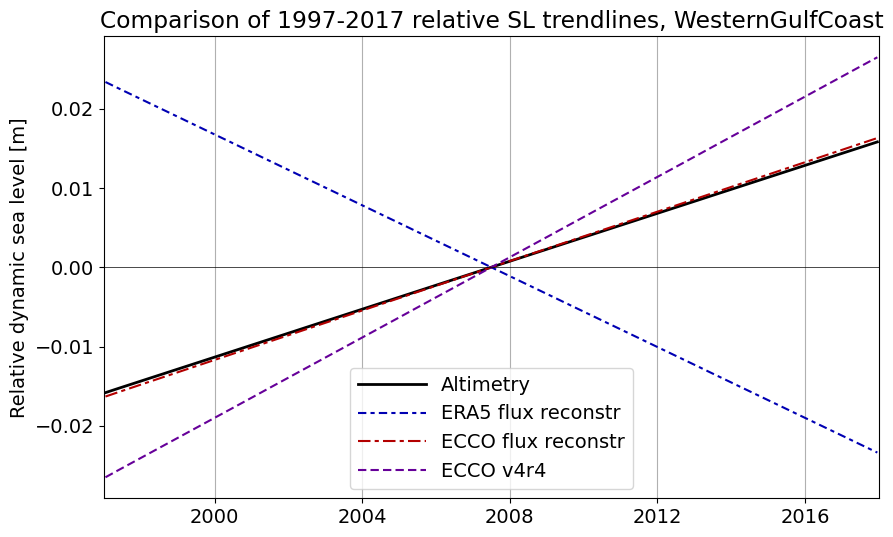

In [8]:
plt.rcParams['font.size'] = 14
fig,ax = plt.subplots(1,1,figsize=(10,6))
handles = []
h, = ax.plot(time_monthly,altim_trendline,color=(0,0,0),linewidth=2,label='Altimetry')
handles.append(h)
h, = ax.plot(time_monthly,ERA5_reconstr_trendline,color=(0,0,.7),linewidth=1.5,linestyle=(0,(4,2,2,2)),\
            label='ERA5 flux reconstr')
handles.append(h)
h, = ax.plot(time_monthly,ECCO_reconstr_trendline,color=(.7,0,0),linewidth=1.5,linestyle=(0,(6,2,2,2)),\
            label='ECCO flux reconstr')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_trendline,color=(.4,0,.6),linewidth=1.5,linestyle=(0,(4,2)),label='ECCO v4r4')
handles.append(h)
ax.set_xlim(np.datetime64(str(years_to_predict[0])+'-01-01','ns'),\
            np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns'))
ax.grid(axis='x')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.set_ylabel('Relative dynamic sea level [m]')
ax.set_title('Comparison of '+year_range_id.replace('_','-')+' relative SL trendlines, '+place_id)
ax.legend(handles=handles,handlelength=3.5)
plt.savefig(f'RSL_tseries_altim_v4r4_reconstr_trendlines_{place_id}_{year_range_id}.png')
plt.show()

In [5]:
# load time-mean IC and zero-anom forcing llc90 simulations

def v4r4_SSH_case_inregion(SSH_files_path,region_wet_mask_v4,curr_years_incase):
    """Compute in-region monthly means of SSH from a specific case/run of ECCOv4r4"""
    files_case = glob.glob(SSH_files_path)
    files_case.sort()
    
    time_case = np.empty((len(files_case),)).astype('datetime64[ns]')
    SSH_case = np.empty((len(files_case),13,90,90))
    SSH_case.fill(np.nan)
    for file_count,curr_filename in enumerate(files_case):
        hrs_tstep = int(curr_filename.split('.')[-2])
        curr_month = (np.datetime64('1992-01-01','ns') + np.timedelta64(hrs_tstep,'h')).astype('datetime64[M]')
        curr_midmonth = curr_month.astype('datetime64[ns]') + \
                            (((curr_month + np.timedelta64(1,'M')).astype('datetime64[ns]')\
                             - curr_month.astype('datetime64[ns]'))/2)
        time_case[file_count] = curr_midmonth
        curr_data_unshaped = np.fromfile(curr_filename,dtype='>f4')
        if '052e' in SSH_files_path:
            SSH_case[file_count,:,:,:] = data_llcshape(curr_data_unshaped)[2,:,:,:]
        else:
            SSH_case[file_count,:,:,:] = data_llcshape(curr_data_unshaped)
    
    ds_ECCO_case = xr.Dataset(data_vars={'SSH':(['time','tile','j','i'],SSH_case)},\
                              coords={**ds_ECCO_v4r4.isel(time=0).coords,**{'time':time_case}})
    
    time_case_ind = np.logical_and(ds_ECCO_case.time.values >= np.datetime64(str(curr_years_incase[0])+'-01-01','ns'),\
                               ds_ECCO_case.time.values < np.datetime64(str(curr_years_incase[-1]+1)+'-01-01','ns'))\
                                .nonzero()[0]
    SSH_case = ds_ECCO_case.SSH.isel(time=time_case_ind)
    
    SSH_case_globmean = ((wet_mask_v4*ds_grid.rA*SSH_case).sum(['i','j','tile'])\
                            /((wet_mask_v4*ds_grid.rA).sum(['i','j','tile']))).values
    
    SSH_case_inregion = np.zeros((len(time_case_ind),))
    for curr_ind in np.asarray(in_region_ind).transpose():
        curr_ind_dict = {'tile':curr_ind[0],'j':curr_ind[1],'i':curr_ind[2]}    
        SSH_case_inregion += (region_wet_mask_v4*ds_grid.rA*SSH_case).isel(curr_ind_dict).values
    SSH_case_inregion = SSH_case_inregion/area_v4_inregion

    return SSH_case_inregion,SSH_case_globmean


# in_region mean of time-mean IC llc90 simulation
SSH_052e_inregion,SSH_052e_globmean = v4r4_SSH_case_inregion(\
                            join(expanduser('~'),'Downloads','ECCO_v4r4_052e','SSH_mon_mean',\
                                 'state_2d_ssh_mon_mean.*.data'),\
                            wet_mask_v4,years_to_predict)

# in_region mean of Jan 1992 IC + time-mean forcing llc90 simulation
SSH_075c_inregion,SSH_075c_globmean = v4r4_SSH_case_inregion(\
                            join(expanduser('~'),'Downloads','ECCO_v4r4_075c','diags_monthly',\
                                 'SSH_mon_mean','SSH_mon_mean.*.data'),\
                            wet_mask_v4,years_to_predict)

# Remove global means
SSH_052e_inregion -= SSH_052e_globmean
SSH_075c_inregion -= SSH_075c_globmean

# Remove seasonal cycle
v4r4_052e_noseas = seas_cycle_remove(SSH_052e_inregion,time_monthly)
v4r4_075c_noseas = seas_cycle_remove(SSH_075c_inregion,time_monthly)

# remove time means from last 8 years (2010-2017)
altim_noseas_nomeanlast8yr = altim_noseas - np.nanmean(altim_noseas[-96:])
ECCO_reconstr_nomeanlast8yr = ECCO_reconstr_noseas - np.nanmean(ECCO_reconstr_noseas[-96:])
v4r4_noseas_nomeanlast8yr = v4r4_noseas - np.nanmean(v4r4_noseas[-96:])
v4r4_052e_noseas -= np.nanmean(v4r4_052e_noseas[-96:])
v4r4_075c_noseas -= np.nanmean(v4r4_075c_noseas[-96:])



# for full range of times ("alltimes")
SSH_075c_alltimes_inregion,SSH_075c_alltimes_globmean = v4r4_SSH_case_inregion(\
                            join(expanduser('~'),'Downloads','ECCO_v4r4_075c','diags_monthly',\
                                 'SSH_mon_mean','SSH_mon_mean.*.data'),\
                            wet_mask_v4,curr_years_incase=np.arange(1992,2018))

SSH_075c_alltimes_inregion -= SSH_075c_alltimes_globmean

# Remove seasonal cycle
v4r4_075c_alltimes_noseas = seas_cycle_remove(SSH_075c_alltimes_inregion,ds_ECCO_v4r4.time.values)

# remove time means from last 8 years (2010-2017)
v4r4_075c_alltimes_noseas -= np.nanmean(v4r4_075c_alltimes_noseas[-96:])

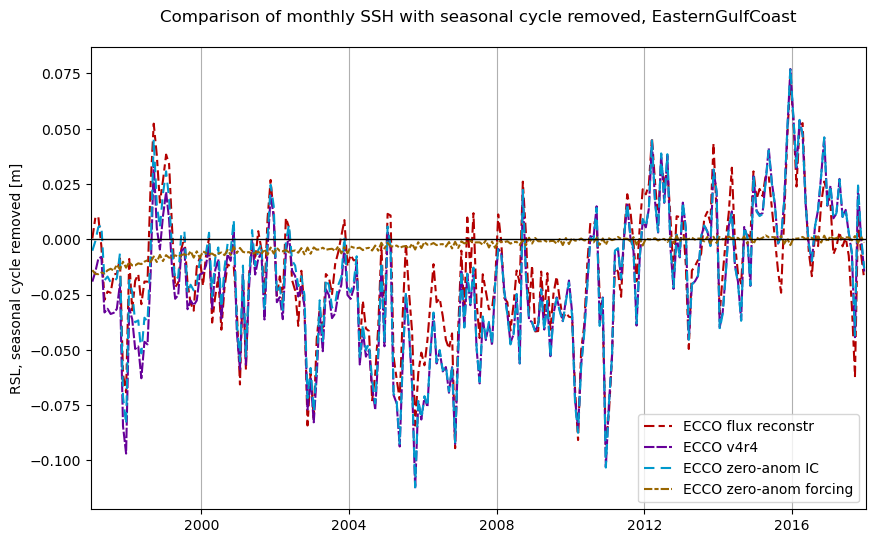

In [10]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
handles = []
h, = ax.plot(time_monthly,ECCO_reconstr_nomeanlast8yr,color=(.7,0,0),linewidth=1.5,linestyle=(0,(5,2,3,2)),\
            label='ECCO flux reconstr')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_noseas_nomeanlast8yr,color=(.4,0,.6),linewidth=1.5,linestyle=(0,(5,1)),label='ECCO v4r4')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_052e_noseas,color=(0,.6,.8),linewidth=1.5,linestyle=(0,(5,3)),label='ECCO zero-anom IC')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_075c_noseas,color=(.6,.4,0),linewidth=1.5,linestyle=(0,(4,1,2,1)),\
             label='ECCO zero-anom forcing')
handles.append(h)
ax.axhline(y=0,color=(0,0,0),linewidth=1)
ax.grid(axis='x')
ax.set_xlim([np.datetime64(str(years_to_predict[0])+'-01-01','ns'),\
             np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns')])
ax.set_ylabel('RSL, seasonal cycle removed [m]')
ax.set_title('Comparison of monthly SSH with seasonal cycle removed, '+place_id+'\n')
ax.legend(handles=handles)
plt.savefig(f'RSL_tseries_ICimpact_stateest_reconstr_{place_id}_{year_range_id}.png')
plt.show()

C:\Users\adelman\Documents\py_functions\filter_functions.py:45: RuntimeWarning: divide by zero encountered in log
  bandpass_filter = 0.5*(special.erf(steepness_factor*(np.log(np.abs(f_vec)) - np.log(low_bound/half_power_adj))) - special.erf(steepness_factor*(np.log(np.abs(f_vec)) - np.log(high_bound*half_power_adj))))


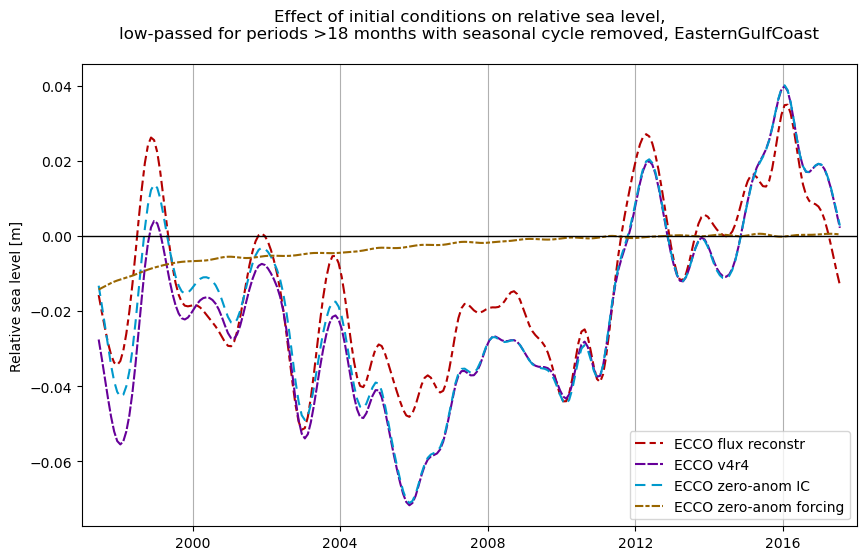

In [11]:
def trendline_18molp_compute(tseries):
    tseries_lp,trendline = bandpass_err_fcn(tseries,axis=-1,delta_dim=365.24/12,\
                                            high_bound=1/(1.5*365.24),steepness_factor=2,edge_handling_opt=1)
    
    return tseries_lp,trendline

ECCO_reconstr_18molp,ECCO_reconstr_trendline = trendline_18molp_compute(ECCO_reconstr_nomeanlast8yr)
v4r4_18molp,v4r4_trendline = trendline_18molp_compute(v4r4_noseas_nomeanlast8yr)
v4r4_052e_18molp,v4r4_052e_trendline = trendline_18molp_compute(v4r4_052e_noseas)
v4r4_075c_18molp,v4r4_075c_trendline = trendline_18molp_compute(v4r4_075c_noseas)

fig,ax = plt.subplots(1,1,figsize=(10,6))
handles = []
h, = ax.plot(time_monthly,ECCO_reconstr_18molp,color=(.7,0,0),linewidth=1.5,linestyle=(0,(5,2,3,2)),\
            label='ECCO flux reconstr')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_18molp,color=(.4,0,.6),linewidth=1.5,linestyle=(0,(5,1)),label='ECCO v4r4')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_052e_18molp,color=(0,.6,.8),linewidth=1.5,linestyle=(0,(5,3)),\
             label='ECCO zero-anom IC')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_075c_18molp,color=(.6,.4,0),linewidth=1.5,linestyle=(0,(4,1,2,1)),\
             label='ECCO zero-anom forcing')
handles.append(h)
ax.axhline(y=0,color=(0,0,0),linewidth=1)
ax.grid(axis='x')
ax.set_xlim([np.datetime64(str(years_to_predict[0])+'-01-01','ns'),\
             np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns')])
ax.set_ylabel('Relative sea level [m]')
ax.set_title('Effect of initial conditions on relative sea level,\n'\
             +'low-passed for periods >18 months with seasonal cycle removed, '+place_id+'\n')
ax.legend(handles=handles)
plt.savefig(f'RSL_tseries_ICimpact_stateest_reconstr_18molp_{place_id}_{year_range_id}.png')

In [6]:
altim_10yrlp,altim_trendline = trendline_10yrlp_compute(altim_noseas_nomeanlast8yr)
ECCO_reconstr_10yrlp,ECCO_reconstr_trendline = trendline_10yrlp_compute(ECCO_reconstr_nomeanlast8yr)
v4r4_10yrlp,v4r4_trendline = trendline_10yrlp_compute(v4r4_noseas_nomeanlast8yr)
v4r4_052e_10yrlp,v4r4_052e_trendline = trendline_10yrlp_compute(v4r4_052e_noseas)
v4r4_075c_10yrlp,v4r4_075c_trendline = trendline_10yrlp_compute(v4r4_075c_noseas)

C:\Users\adelman\Documents\py_functions\filter_functions.py:45: RuntimeWarning: divide by zero encountered in log
  bandpass_filter = 0.5*(special.erf(steepness_factor*(np.log(np.abs(f_vec)) - np.log(low_bound/half_power_adj))) - special.erf(steepness_factor*(np.log(np.abs(f_vec)) - np.log(high_bound*half_power_adj))))


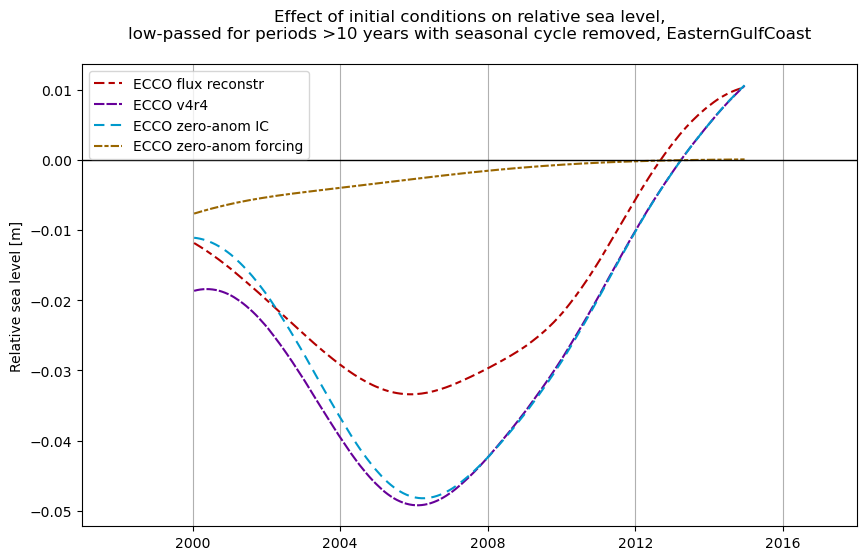

In [13]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
handles = []
h, = ax.plot(time_monthly,ECCO_reconstr_10yrlp,color=(.7,0,0),linewidth=1.5,linestyle=(0,(5,2,3,2)),\
            label='ECCO flux reconstr')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_10yrlp,color=(.4,0,.6),linewidth=1.5,linestyle=(0,(5,1)),label='ECCO v4r4')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_052e_10yrlp,color=(0,.6,.8),linewidth=1.5,linestyle=(0,(5,3)),\
             label='ECCO zero-anom IC')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_075c_10yrlp,color=(.6,.4,0),linewidth=1.5,linestyle=(0,(4,1,2,1)),\
             label='ECCO zero-anom forcing')
handles.append(h)
ax.axhline(y=0,color=(0,0,0),linewidth=1)
ax.grid(axis='x')
ax.set_xlim([np.datetime64(str(years_to_predict[0])+'-01-01','ns'),\
             np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns')])
ax.set_ylabel('Relative sea level [m]')
ax.set_title('Effect of initial conditions on relative sea level,\n'\
             +'low-passed for periods >10 years with seasonal cycle removed, '+place_id+'\n')
ax.legend(handles=handles)
plt.savefig(f'RSL_tseries_ICimpact_stateest_reconstr_10yrlp_{place_id}_{year_range_id}.png')

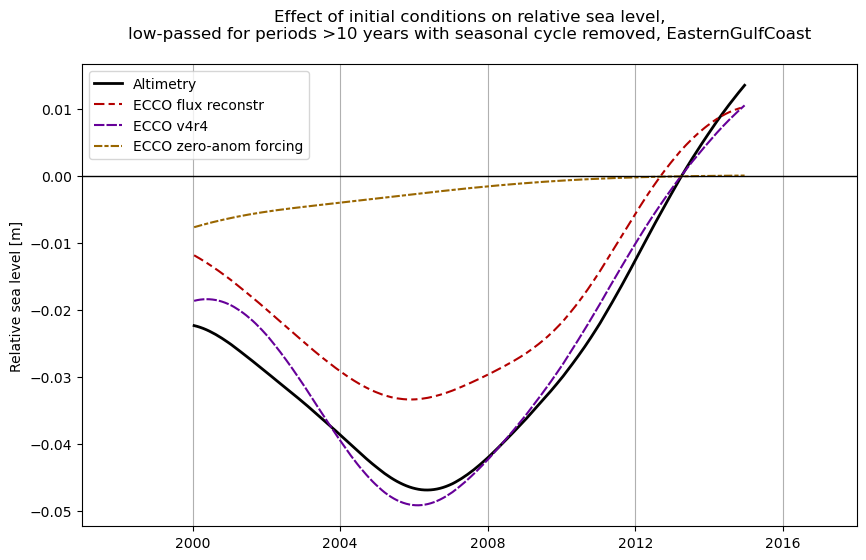

In [14]:
# alternate version of this plot

fig,ax = plt.subplots(1,1,figsize=(10,6))
handles = []
h, = ax.plot(time_monthly,altim_10yrlp,color=(0,0,0),linewidth=2,label='Altimetry')
handles.append(h)
h, = ax.plot(time_monthly,ECCO_reconstr_10yrlp,color=(.7,0,0),linewidth=1.5,linestyle=(0,(5,2,3,2)),\
            label='ECCO flux reconstr')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_10yrlp,color=(.4,0,.6),linewidth=1.5,linestyle=(0,(5,1)),label='ECCO v4r4')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_075c_10yrlp,color=(.6,.4,0),linewidth=1.5,linestyle=(0,(4,1,2,1)),\
             label='ECCO zero-anom forcing')
handles.append(h)
ax.axhline(y=0,color=(0,0,0),linewidth=1)
ax.grid(axis='x')
ax.set_xlim([np.datetime64(str(years_to_predict[0])+'-01-01','ns'),\
             np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns')])
ax.set_ylabel('Relative sea level [m]')
ax.set_title('Effect of initial conditions on relative sea level,\n'\
             +'low-passed for periods >10 years with seasonal cycle removed, '+place_id+'\n')
ax.legend(handles=handles)
plt.savefig(f'RSL_tseries_altim_ICimpact_stateest_reconstr_10yrlp_{place_id}_{year_range_id}.png')

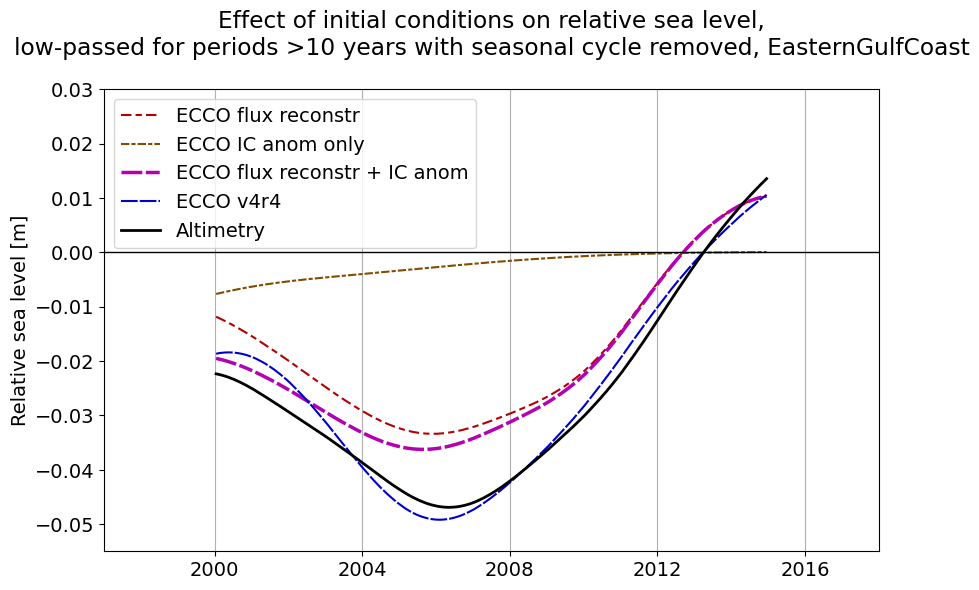

In [9]:
# alternate version of this plot

plt.rcParams['font.size'] = 14
fig,ax = plt.subplots(1,1,figsize=(10,6))
handles = []
h, = ax.plot(time_monthly,ECCO_reconstr_10yrlp,color=(.7,0,0),linewidth=1.5,linestyle=(0,(5,2,3,2)),\
            label='ECCO flux reconstr')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_075c_10yrlp,color=(.5,.3,0),linewidth=1.5,linestyle=(0,(4,1,2,1)),\
             label='ECCO IC anom only')
handles.append(h)
h, = ax.plot(time_monthly,ECCO_reconstr_10yrlp + v4r4_075c_10yrlp,color=(.7,0,.7),linewidth=2.5,linestyle=(0,(6,1,4,1)),\
             label='ECCO flux reconstr + IC anom')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_10yrlp,color=(0,0,.8),linewidth=1.5,linestyle=(0,(8,1)),label='ECCO v4r4')
handles.append(h)
h, = ax.plot(time_monthly,altim_10yrlp,color=(0,0,0),linewidth=2,label='Altimetry')
handles.append(h)
ax.axhline(y=0,color=(0,0,0),linewidth=1)
ax.set_ylim([-.055,.03])
ax.grid(axis='x')
ax.set_xlim([np.datetime64(str(years_to_predict[0])+'-01-01','ns'),\
             np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns')])
ax.set_ylabel('Relative sea level [m]')
ax.set_title('Effect of initial conditions on relative sea level,\n'\
             +'low-passed for periods >10 years with seasonal cycle removed, '+place_id+'\n')
ax.legend(handles=handles)
plt.savefig(f'RSL_tseries_reconstr_ICimpact_stateest_altim_10yrlp_{place_id}_{year_range_id}.png')

In [7]:
# include filtered full timeseries of altimetry & ERA5-based reconstruction

SSH_altim_alltimes = ds_ERA5_reconstr.obs_tseries_sortmonth.values.transpose().flatten()
SSH_ERA5_reconstr_alltimes = ds_ERA5_reconstr.reconstr_total.values.transpose().flatten()
time_monthly_ERA5_alltimes = ds_ERA5_reconstr.pred_time.values.transpose().flatten()



SSH_v4r4_alltimes = ds_ECCO_v4r4.SSH
time_monthly_v4r4_alltimes = ds_ECCO_v4r4.time.values
wet_mask_v4 = ds_grid.maskC.isel(k=0)
SSH_v4r4_alltimes_globmean = ((wet_mask_v4*ds_grid.rA*SSH_v4r4_alltimes).sum(['i','j','tile'])\
                        /((wet_mask_v4*ds_grid.rA).sum(['i','j','tile']))).values
# compute state estimate averages in mask region
area_v4_inregion = 0
SSH_v4r4_alltimes_inregion = np.zeros((len(time_monthly_v4r4_alltimes),))
for curr_ind in np.asarray(in_region_ind).transpose():
    curr_ind_dict = {'tile':curr_ind[0],'j':curr_ind[1],'i':curr_ind[2]}
    area_v4_inregion += (wet_mask_v4*ds_grid.rA).isel(curr_ind_dict).values
    SSH_v4r4_alltimes_inregion += (wet_mask_v4*ds_grid.rA*SSH_v4r4_alltimes).isel(curr_ind_dict).values
SSH_v4r4_alltimes_inregion = SSH_v4r4_alltimes_inregion/area_v4_inregion
# remove global mean
SSH_v4r4_alltimes_inregion -= SSH_v4r4_alltimes_globmean
# remove time mean
SSH_v4r4_alltimes_inregion -= np.nanmean(SSH_v4r4_alltimes_inregion)


altim_alltimes_noseas = seas_cycle_remove(SSH_altim_alltimes,time_monthly_ERA5_alltimes)
ERA5_reconstr_alltimes_noseas = seas_cycle_remove(SSH_ERA5_reconstr_alltimes,time_monthly_ERA5_alltimes)
SSH_v4r4_alltimes_noseas = seas_cycle_remove(SSH_v4r4_alltimes_inregion,time_monthly_v4r4_alltimes)

altim_alltimes_10yrlp,altim_alltimes_trendline = trendline_10yrlp_compute(altim_alltimes_noseas,edge_handling_opt=0)
ERA5_reconstr_alltimes_10yrlp,ERA5_reconstr_alltimes_trendline = trendline_10yrlp_compute(ERA5_reconstr_alltimes_noseas,edge_handling_opt=0)
SSH_v4r4_alltimes_10yrlp,SSH_v4r4_alltimes_trendline = trendline_10yrlp_compute(SSH_v4r4_alltimes_noseas,edge_handling_opt=0)
v4r4_075c_alltimes_10yrlp,v4r4_075c_alltimes_trendline = trendline_10yrlp_compute(v4r4_075c_alltimes_noseas,edge_handling_opt=0)


ECCO_years_to_predict = np.arange(1997,2018)
ECCO_in_ERA5_time_range_ind = np.logical_and(time_monthly_ERA5_alltimes >= np.datetime64(str(ECCO_years_to_predict[0])+'-01-01','ns'),\
                                             time_monthly_ERA5_alltimes <= np.datetime64(str(ECCO_years_to_predict[-1]+1)+'-01-01','ns')).nonzero()[0]
altim_alltimes_10yrlp -= np.nanmean(altim_alltimes_noseas[ECCO_in_ERA5_time_range_ind])
ERA5_reconstr_alltimes_10yrlp -= np.nanmean(ERA5_reconstr_alltimes_noseas[ECCO_in_ERA5_time_range_ind])
ECCO_in_v4r4_time_range_ind = np.logical_and(time_monthly_v4r4_alltimes >= np.datetime64(str(ECCO_years_to_predict[0])+'-01-01','ns'),\
                                             time_monthly_v4r4_alltimes <= np.datetime64(str(ECCO_years_to_predict[-1]+1)+'-01-01','ns')).nonzero()[0]
SSH_v4r4_alltimes_10yrlp -= np.nanmean(SSH_v4r4_alltimes_noseas[ECCO_in_v4r4_time_range_ind])

C:\Users\adelman\Documents\py_functions\filter_functions.py:45: RuntimeWarning: divide by zero encountered in log
  bandpass_filter = 0.5*(special.erf(steepness_factor*(np.log(np.abs(f_vec)) - np.log(low_bound/half_power_adj))) - special.erf(steepness_factor*(np.log(np.abs(f_vec)) - np.log(high_bound*half_power_adj))))


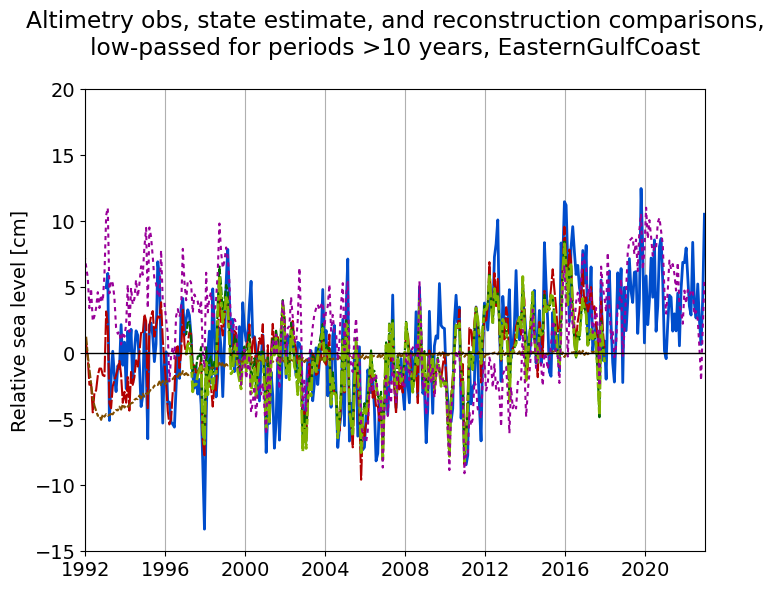

In [9]:
plt.rcParams['font.size'] = 14
fig,ax = plt.subplots(1,1,figsize=(8,6))
handles = []
h, = ax.plot(time_monthly_ERA5_alltimes,100*(altim_alltimes_noseas\
                                             - np.nanmean(altim_alltimes_noseas[ECCO_in_ERA5_time_range_ind])),\
                                             color=(0,.3,.8),linewidth=2,label='Altimetry')
handles.append(h)
h, = ax.plot(time_monthly_v4r4_alltimes,100*(SSH_v4r4_alltimes_noseas\
                                             - np.nanmean(SSH_v4r4_alltimes_noseas[ECCO_in_v4r4_time_range_ind])),\
                                             color=(.7,0,0),linewidth=1.5,linestyle=(0,(8,1)),label='v4r4 state est')
handles.append(h)
h, = ax.plot(time_monthly,100*(ECCO_reconstr_noseas\
                                     - np.nanmean(ECCO_reconstr_noseas)),color=(0,.4,0),linewidth=1.5,linestyle=(2,(4,1)),\
            label='ECCO adj reconstr')
handles.append(h)
h, = ax.plot(time_monthly_v4r4_alltimes,100*v4r4_075c_alltimes_noseas,color=(.5,.3,0),linewidth=1.5,linestyle=(0,(4,1,2,1)),\
             label='ECCO 1992 IC anom only')
handles.append(h)
h, = ax.plot(time_monthly,100*(ECCO_reconstr_noseas + v4r4_075c_alltimes_noseas[60:]\
                                     - np.nanmean(ECCO_reconstr_noseas)),color=(.5,.7,0),linewidth=2,linestyle=(0,(5,1,2,1)),\
             label='ECCO adj reconstr + 1992 IC anom')
handles.append(h)
h, = ax.plot(time_monthly_ERA5_alltimes,100*(ERA5_reconstr_alltimes_noseas\
                                             - np.nanmean(ERA5_reconstr_alltimes_noseas[ECCO_in_ERA5_time_range_ind])),\
             color=(.6,0,.6),linewidth=1.5,linestyle=(2,(2,2)),\
            label='ERA5 adj reconstr')
handles.append(h)
ax.axhline(y=0,color=(0,0,0),linewidth=1)
ax.set_ylim([-15,20])
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1992-01-01','ns'),\
             np.datetime64('2023-01-01','ns')])
ax.set_ylabel('Relative sea level [cm]')
ax.set_title('Altimetry obs, state estimate, and reconstruction comparisons,\n'\
             +'low-passed for periods >10 years, '+place_id+'\n')
ax.legend(handles=handles)
plt.savefig(f'RSL_noseas_tseries_reconstrs_ICimpact_stateest_altim_{place_id}_{year_range_id}.png')
plt.show()

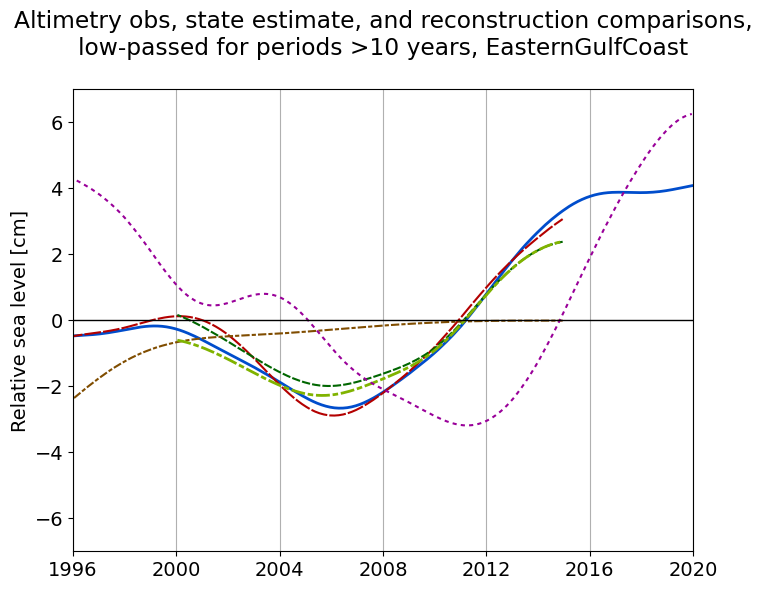

In [10]:
plt.rcParams['font.size'] = 14
fig,ax = plt.subplots(1,1,figsize=(8,6))
handles = []
h, = ax.plot(time_monthly_ERA5_alltimes[144:-36],100*altim_alltimes_10yrlp[144:-36],color=(0,.3,.8),linewidth=2,label='Altimetry')
handles.append(h)
h, = ax.plot(time_monthly_v4r4_alltimes[36:-36],100*SSH_v4r4_alltimes_10yrlp[36:-36],color=(.7,0,0),linewidth=1.5,linestyle=(0,(8,1)),label='v4r4 state est')
handles.append(h)
h, = ax.plot(time_monthly[36:-36],100*(ECCO_reconstr_10yrlp[36:-36]\
                                     - np.nanmean(ECCO_reconstr_nomeanlast8yr)),color=(0,.4,0),linewidth=1.5,linestyle=(2,(4,1)),\
            label='ECCO adj reconstr')
handles.append(h)
h, = ax.plot(time_monthly_v4r4_alltimes[36:-36],100*v4r4_075c_alltimes_10yrlp[36:-36],color=(.5,.3,0),linewidth=1.5,linestyle=(0,(4,1,2,1)),\
             label='ECCO 1992 IC anom only')
handles.append(h)
h, = ax.plot(time_monthly[36:-36],100*(ECCO_reconstr_10yrlp[36:-36] + v4r4_075c_10yrlp[36:-36]\
                                     - np.nanmean(ECCO_reconstr_nomeanlast8yr)),color=(.5,.7,0),linewidth=2,linestyle=(0,(5,1,2,1)),\
             label='ECCO adj reconstr + 1992 IC anom')
handles.append(h)
h, = ax.plot(time_monthly_ERA5_alltimes[36:-36],100*ERA5_reconstr_alltimes_10yrlp[36:-36],color=(.6,0,.6),linewidth=1.5,linestyle=(2,(2,2)),\
            label='ERA5 adj reconstr')
handles.append(h)
ax.axhline(y=0,color=(0,0,0),linewidth=1)
ax.set_ylim([-7,7])
ax.grid(axis='x')
ax.set_xlim([np.datetime64('1996-01-01','ns'),\
             np.datetime64('2020-01-01','ns')])
ax.set_ylabel('Relative sea level [cm]')
ax.set_title('Altimetry obs, state estimate, and reconstruction comparisons,\n'\
             +'low-passed for periods >10 years, '+place_id+'\n')
ax.legend(handles=handles)
plt.savefig(f'RSL_tseries_reconstrs_ICimpact_stateest_altim_10yrlp_{place_id}_{year_range_id}.png')
plt.show()

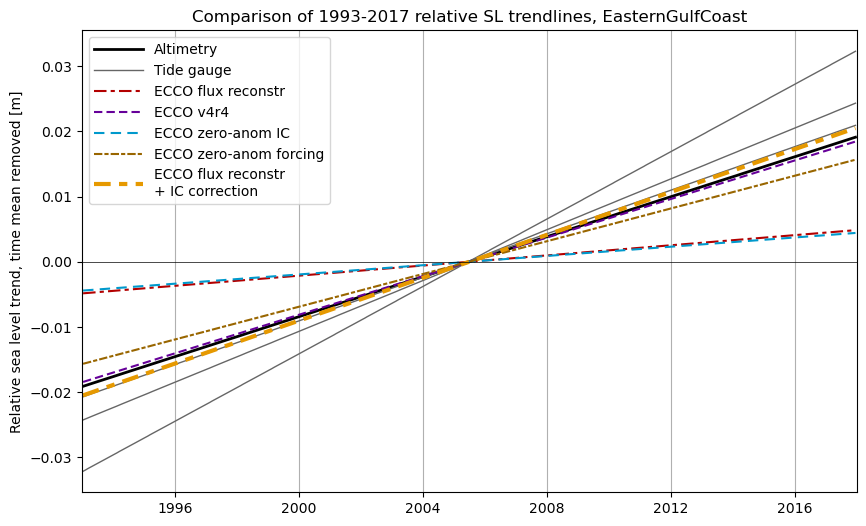

In [31]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
handles = []
h, = ax.plot(time_monthly,altim_trendline,color=(0,0,0),linewidth=2,label='Altimetry')
handles.append(h)
for tgauge_count,curr_tseries in enumerate(tgauge_trendline):
    h, = ax.plot(time_monthly,curr_tseries,color=(.4,.4,.4),linewidth=1,label='Tide gauge')
    if tgauge_count == 0:
        handles.append(h)
h, = ax.plot(time_monthly,ECCO_reconstr_trendline\
              - np.nanmean(ECCO_reconstr_trendline),color=(.7,0,0),linewidth=1.5,linestyle=(0,(6,2,2,2)),\
            label='ECCO flux reconstr')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_trendline\
              - np.nanmean(v4r4_trendline),color=(.4,0,.6),linewidth=1.5,linestyle=(0,(4,2)),label='ECCO v4r4')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_052e_trendline\
              - np.nanmean(v4r4_052e_trendline),color=(0,.6,.8),linewidth=1.5,linestyle=(0,(5,3)),\
             label='ECCO zero-anom IC')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_075c_trendline\
              - np.nanmean(v4r4_075c_trendline),color=(.6,.4,0),linewidth=1.5,linestyle=(0,(4,1,2,1)),\
             label='ECCO zero-anom forcing')
handles.append(h)
# h, = ax.plot(time_monthly,ECCO_reconstr_trendline + (v4r4_trendline - v4r4_052e_trendline),\
#              color=(.9,.6,0),linewidth=3,linestyle=(0,(4,2,2,2)),label='ECCO flux reconstr \n+ IC correction')
# handles.append(h)
h, = ax.plot(time_monthly,ECCO_reconstr_trendline + v4r4_075c_trendline\
                           - np.nanmean(ECCO_reconstr_trendline + v4r4_075c_trendline),\
             color=(.9,.6,0),linewidth=3,linestyle=(0,(4,2,2,2)),label='ECCO flux reconstr \n+ IC correction')
handles.append(h)
ax.set_xlim(np.datetime64(str(years_to_predict[0])+'-01-01','ns'),\
            np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns'))
ax.set_ylabel('Relative sea level trend, time mean removed [m]')
ax.grid(axis='x')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.set_title('Comparison of '+year_range_id.replace('_','-')+' relative SL trendlines, '+place_id)
ax.legend(handles=handles,handlelength=3.5)
plt.savefig(f'RSL_tseries_obs_stateest_reconstr_withICcorrec_trendlines_{place_id}_{year_range_id}.png')
plt.show()

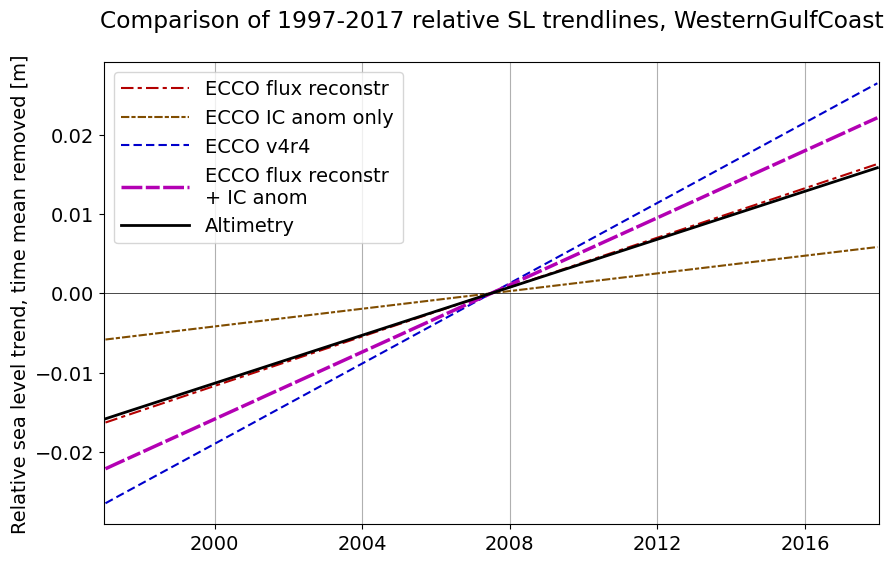

In [18]:
# alternate trendline plot

plt.rcParams['font.size'] = 14
fig,ax = plt.subplots(1,1,figsize=(10,6))
handles = []
h, = ax.plot(time_monthly,ECCO_reconstr_trendline\
              - np.nanmean(ECCO_reconstr_trendline),color=(.7,0,0),linewidth=1.5,linestyle=(0,(6,2,2,2)),\
            label='ECCO flux reconstr')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_075c_trendline\
              - np.nanmean(v4r4_075c_trendline),color=(.5,.3,0),linewidth=1.5,linestyle=(0,(4,1,2,1)),\
             label='ECCO IC anom only')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_trendline\
              - np.nanmean(v4r4_trendline),color=(0,0,.8),linewidth=1.5,linestyle=(0,(4,2)),label='ECCO v4r4')
handles.append(h)
h, = ax.plot(time_monthly,ECCO_reconstr_trendline + v4r4_075c_trendline\
                           - np.nanmean(ECCO_reconstr_trendline + v4r4_075c_trendline),\
             color=(.7,0,.7),linewidth=2.5,linestyle=(0,(6,1,4,1)),label='ECCO flux reconstr \n+ IC anom')
handles.append(h)
h, = ax.plot(time_monthly,altim_trendline - np.nanmean(altim_trendline),color=(0,0,0),linewidth=2,label='Altimetry')
handles.append(h)
ax.set_xlim(np.datetime64(str(years_to_predict[0])+'-01-01','ns'),\
            np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns'))
ax.set_ylabel('Relative sea level trend, time mean removed [m]')
ax.grid(axis='x')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.set_title('Comparison of '+year_range_id.replace('_','-')+' relative SL trendlines, '+place_id+'\n')
ax.legend(handles=handles,handlelength=3.5)
plt.savefig(f'RSL_tseries_reconstr_stateest_obs_withICcorrec_trendlines_{place_id}_{year_range_id}.png')
plt.show()

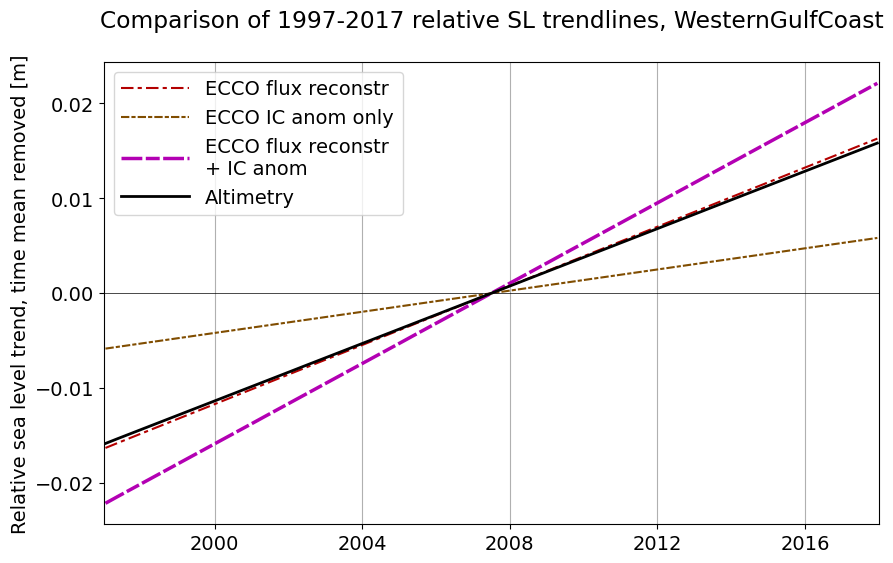

In [19]:
# yet another trendline plot (no v4r4)

plt.rcParams['font.size'] = 14
fig,ax = plt.subplots(1,1,figsize=(10,6))
handles = []
h, = ax.plot(time_monthly,ECCO_reconstr_trendline\
              - np.nanmean(ECCO_reconstr_trendline),color=(.7,0,0),linewidth=1.5,linestyle=(0,(6,2,2,2)),\
            label='ECCO flux reconstr')
handles.append(h)
h, = ax.plot(time_monthly,v4r4_075c_trendline\
              - np.nanmean(v4r4_075c_trendline),color=(.5,.3,0),linewidth=1.5,linestyle=(0,(4,1,2,1)),\
             label='ECCO IC anom only')
handles.append(h)
h, = ax.plot(time_monthly,ECCO_reconstr_trendline + v4r4_075c_trendline\
                           - np.nanmean(ECCO_reconstr_trendline + v4r4_075c_trendline),\
             color=(.7,0,.7),linewidth=2.5,linestyle=(0,(6,1,4,1)),label='ECCO flux reconstr \n+ IC anom')
handles.append(h)
h, = ax.plot(time_monthly,altim_trendline - np.nanmean(altim_trendline),color=(0,0,0),linewidth=2,label='Altimetry')
handles.append(h)
ax.set_xlim(np.datetime64(str(years_to_predict[0])+'-01-01','ns'),\
            np.datetime64(str(years_to_predict[-1]+1)+'-01-01','ns'))
ax.set_ylabel('Relative sea level trend, time mean removed [m]')
ax.grid(axis='x')
ax.axhline(y=0,color=(0,0,0),linewidth=0.5)
ax.set_title('Comparison of '+year_range_id.replace('_','-')+' relative SL trendlines, '+place_id+'\n')
ax.legend(handles=handles,handlelength=3.5)
plt.savefig(f'RSL_tseries_reconstr_obs_withICcorrec_trendlines_{place_id}_{year_range_id}.png')
plt.show()

In [14]:
int(files_052e[0].split('.')[-2])

732

In [ ]:
data = np.fromfile(curr_filename,dtype='>f4')
    
data_inshape = data_llcshape(data)

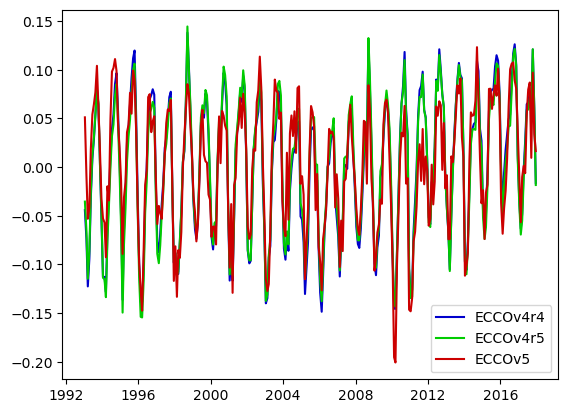

In [12]:
import matplotlib.pyplot as plt

plt.plot(time_monthly,SSH_v4r4_inregion,color=(0,0,.8),label='ECCO v4r4')
plt.plot(time_monthly,SSH_v4r5_inregion,color=(0,.8,0),label='ECCO v4r5')
plt.plot(time_monthly,SSH_v5_inregion,color=(.8,0,0),label='ECCO v5')
plt.legend()

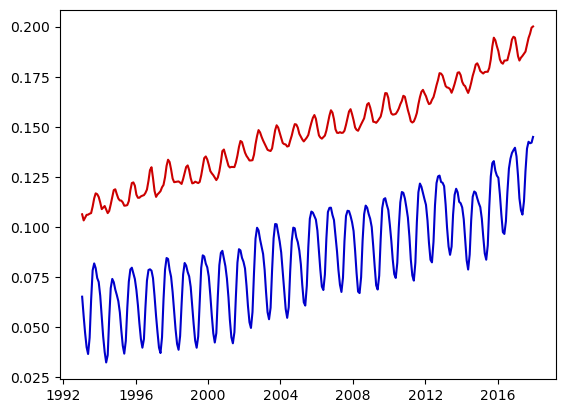

In [14]:
import matplotlib.pyplot as plt

plt.plot(time_monthly,SSH_v4r4_globmean,color=(.8,0,0))
plt.plot(time_monthly,ETAN_v4r4_globmean,color=(0,0,.8))

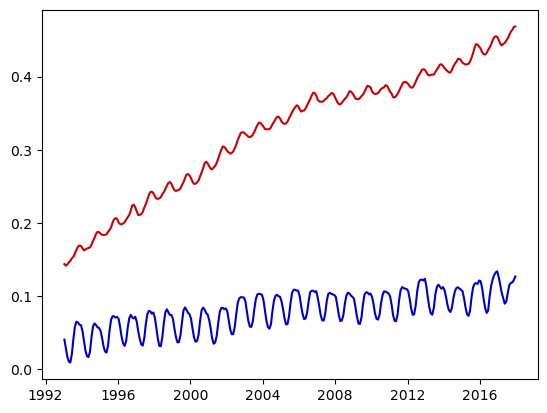

In [13]:
import matplotlib.pyplot as plt

plt.plot(time_monthly,SSH_v4r5_globmean,color=(.8,0,0))
plt.plot(time_monthly,ETAN_v5_globmean,color=(0,0,.8))